<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/neural_ipinn_21_02_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 837.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load the data
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864]
}
df = pd.DataFrame(data)

# Extract time points and gene expression data
time_points = np.array([1.0, 2.0, 4.0])  # Time points (1d, 2d, 4d)
gene_expressions = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (4 genes, 3 time points)

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32)
gene_expressions_tensor = torch.tensor(gene_expressions, dtype=torch.float32)

In [ ]:
class ODEFunc(nn.Module):
    def __init__(self, n_genes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # Input: time, Output: hidden state
            nn.Tanh(),
            nn.Linear(16, n_genes)  # Output: derivatives for all genes
        )
        self.n_genes = n_genes

    def forward(self, t, y):
        # y: (batch_size, n_genes)
        # t: scalar
        t_tensor = torch.ones_like(y[:, 0]).unsqueeze(-1) * t  # Broadcast t to match y's shape
        return self.net(t_tensor)  # Compute derivatives

class NeuralODEModel(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, t, y0):
        return odeint(self.odefunc, y0, t, method='dopri5')  # Solve ODE

In [ ]:
def inverse_pinn_loss(model, time_points, observed_data):
    # Initial condition (gene expressions at t=1d)
    y0 = observed_data[:, 0].unsqueeze(0)  # Shape: (1, n_genes)

    # Solve ODE
    preds = model(time_points, y0).squeeze(0)  # Shape: (n_time_points, n_genes)

    # Compute data loss (MSE between predictions and observed data)
    data_loss = torch.mean((preds - observed_data.T) ** 2)

    return data_loss

In [ ]:
# Initialize model, loss function, and optimizer
n_genes = gene_expressions.shape[0]  # Number of genes
odefunc = ODEFunc(n_genes)
model = NeuralODEModel(odefunc)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Compute loss
    loss = inverse_pinn_loss(model, time_points_tensor, gene_expressions_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 3.9531736373901367
Epoch 100, Loss: 1.7833342552185059
Epoch 200, Loss: 1.764594554901123
Epoch 300, Loss: 1.763683557510376
Epoch 400, Loss: 1.7636733055114746
Epoch 500, Loss: 1.7636733055114746
Epoch 600, Loss: 1.7636733055114746
Epoch 700, Loss: 1.7636733055114746
Epoch 800, Loss: 1.7636733055114746
Epoch 900, Loss: 1.7636733055114746


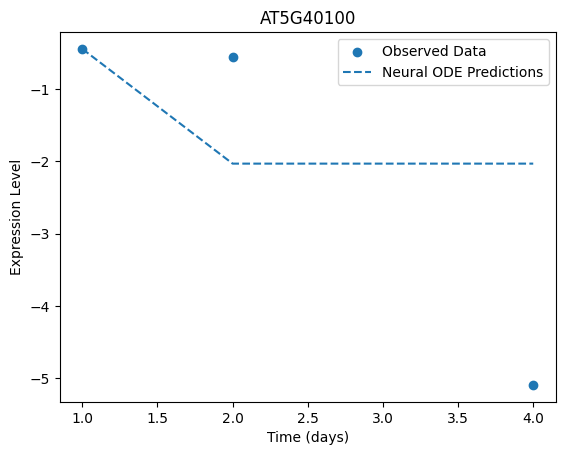

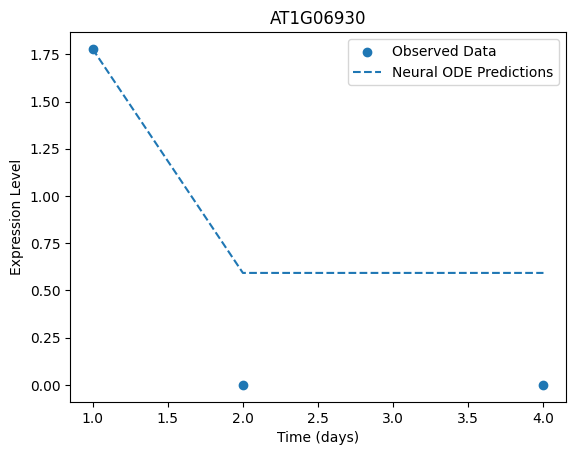

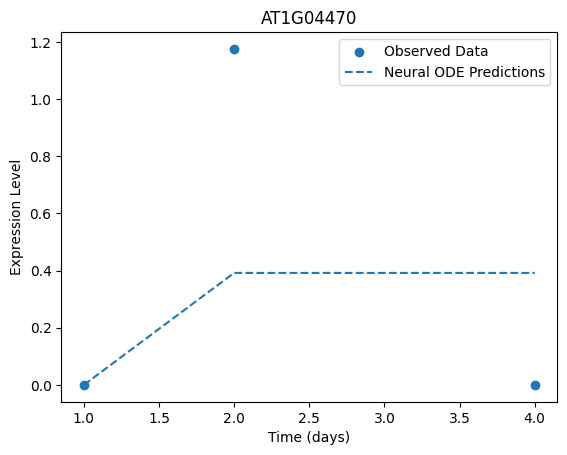

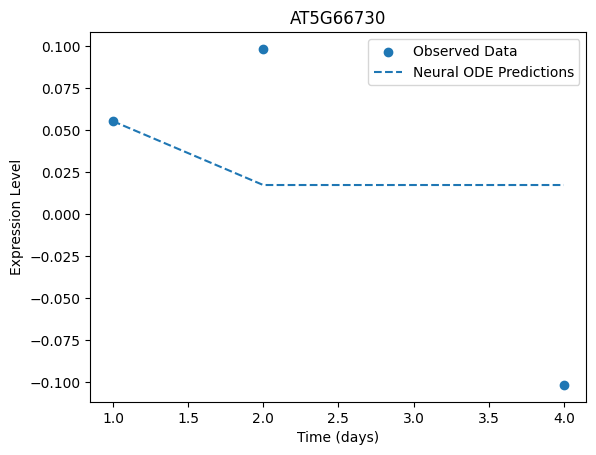

In [ ]:
# Generate predictions
with torch.no_grad():
    y0 = gene_expressions_tensor[:, 0].unsqueeze(0)  # Initial condition
    preds = model(time_points_tensor, y0).squeeze(0).numpy()  # Shape: (n_time_points, n_genes)
    preds = preds.reshape(preds.shape[0],-1) # Reshape preds

# Plot the results
for i, gene_id in enumerate(df["Gene"]):
    plt.figure()
    plt.scatter(time_points, gene_expressions[i], label="Observed Data")
    plt.plot(time_points, preds[:, i], label="Neural ODE Predictions", linestyle="--")  # Access predictions for the current gene
    plt.title(gene_id)
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
    plt.show()

In [ ]:
# Print learned parameters
print("Learned ODE Parameters:")
for name, param in odefunc.named_parameters():
    if param.requires_grad:
        print(f"{name}:")
        print(param.data)

Learned ODE Parameters:
net.0.weight:
tensor([[-0.7741],
        [ 0.0592],
        [-0.3098],
        [-0.4894],
        [ 1.3706],
        [-0.4428],
        [ 1.1434],
        [-0.4368],
        [ 0.3186],
        [ 1.0353],
        [-0.1299],
        [ 0.0145],
        [-0.3327],
        [ 1.3237],
        [-0.6192],
        [ 0.7289]])
net.0.bias:
tensor([-1.0403, -0.1916,  0.4425,  0.9756,  0.3704,  0.5464,  0.4825,  0.9584,
         0.1357,  0.3896,  0.5494,  0.7921,  0.6227,  0.4274,  1.1876,  0.6062])
net.2.weight:
tensor([[ 0.0027,  0.1189, -0.5124, -0.6423, -0.0655, -0.1531, -0.3472, -0.5041,
         -0.2023, -0.1837, -0.3327, -0.2523, -0.7473, -0.2847, -0.2726,  0.0112],
        [ 0.1376,  0.1809, -0.0836, -0.3864, -0.1276, -0.1627, -0.2224, -0.6012,
          0.1096, -0.2185, -0.0186,  0.0603, -0.4745, -0.3060, -0.2574,  0.0046],
        [-0.1005, -0.0407, -0.0267,  0.2770,  0.0640, -0.1700, -0.0642,  0.3193,
         -0.1217,  0.0950, -0.0008, -0.1676,  0.0223,  0.1882, 

In [ ]:
class ODEFunc(nn.Module):
    def __init__(self, n_genes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_genes + 1, 16),  # Input: gene expressions (n_genes) + time (1)
            nn.Tanh(),
            nn.Linear(16, n_genes)  # Output: derivatives for all genes
        )
        self.n_genes = n_genes

    def forward(self, t, y):
        # Concatenate time `t` to the state `y`
        t_tensor = torch.ones_like(y[:, 0]).unsqueeze(-1) * t  # Shape: (batch_size, 1)
        y_with_time = torch.cat([y, t_tensor], dim=1)  # Shape: (batch_size, n_genes + 1)
        return self.net(y_with_time)

In [ ]:
# Extract parameters from the trained model
W1 = odefunc.net[0].weight.detach().numpy()  # Shape: (16, n_genes + 1)
b1 = odefunc.net[0].bias.detach().numpy()     # Shape: (16,)
W2 = odefunc.net[2].weight.detach().numpy()   # Shape: (n_genes, 16)
b2 = odefunc.net[2].bias.detach().numpy()     # Shape: (n_genes,)

# Print ODEs for each gene
print("Learned ODEs:")
for i, gene_id in enumerate(df["Gene"]):
    ode_equation = f"d{gene_id}/dt = "
    for j in range(16):
        # Terms from the first layer (W1[j, :] and b1[j])
        # Access the correct elements of W1 based on its shape
        linear_term = " + ".join([f"{W1[j, 0]:.4f}·y_{k+1}" for k in range(n_genes)]) + f" + {W1[j, 0]:.4f}·t + {b1[j]:.4f}"
        tanh_term = f"tanh({linear_term})"

        # Multiply by W2[i, j] and accumulate
        ode_equation += f"{W2[i, j]:.4f}·{tanh_term} + "

    # Add the bias term b2[i]
    ode_equation += f"{b2[i]:.4f}"
    print(ode_equation + "\n")

Learned ODEs:
dAT5G40100/dt = 0.0027·tanh(-0.7741·y_1 + -0.7741·y_2 + -0.7741·y_3 + -0.7741·y_4 + -0.7741·t + -1.0403) + 0.1189·tanh(0.0592·y_1 + 0.0592·y_2 + 0.0592·y_3 + 0.0592·y_4 + 0.0592·t + -0.1916) + -0.5124·tanh(-0.3098·y_1 + -0.3098·y_2 + -0.3098·y_3 + -0.3098·y_4 + -0.3098·t + 0.4425) + -0.6423·tanh(-0.4894·y_1 + -0.4894·y_2 + -0.4894·y_3 + -0.4894·y_4 + -0.4894·t + 0.9756) + -0.0655·tanh(1.3706·y_1 + 1.3706·y_2 + 1.3706·y_3 + 1.3706·y_4 + 1.3706·t + 0.3704) + -0.1531·tanh(-0.4428·y_1 + -0.4428·y_2 + -0.4428·y_3 + -0.4428·y_4 + -0.4428·t + 0.5464) + -0.3472·tanh(1.1434·y_1 + 1.1434·y_2 + 1.1434·y_3 + 1.1434·y_4 + 1.1434·t + 0.4825) + -0.5041·tanh(-0.4368·y_1 + -0.4368·y_2 + -0.4368·y_3 + -0.4368·y_4 + -0.4368·t + 0.9584) + -0.2023·tanh(0.3186·y_1 + 0.3186·y_2 + 0.3186·y_3 + 0.3186·y_4 + 0.3186·t + 0.1357) + -0.1837·tanh(1.0353·y_1 + 1.0353·y_2 + 1.0353·y_3 + 1.0353·y_4 + 1.0353·t + 0.3896) + -0.3327·tanh(-0.1299·y_1 + -0.1299·y_2 + -0.1299·y_3 + -0.1299·y_4 + -0.1299·t + 0.54

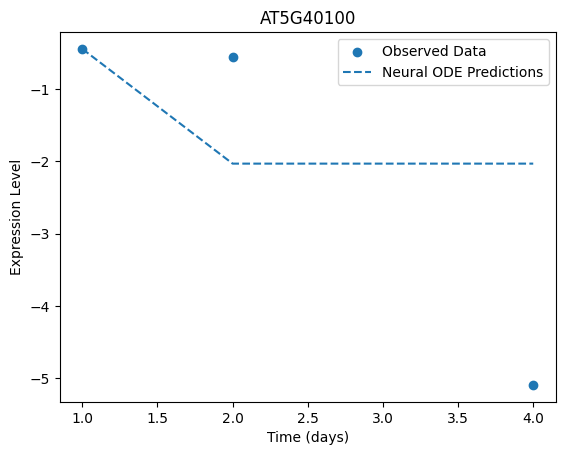

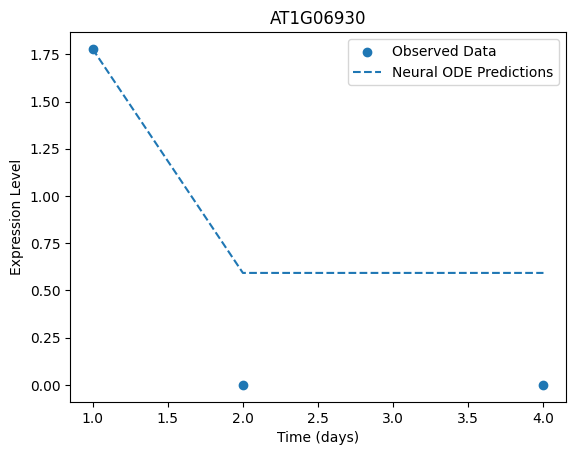

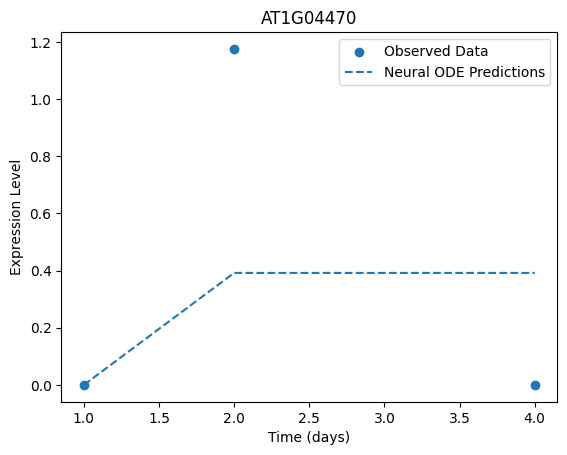

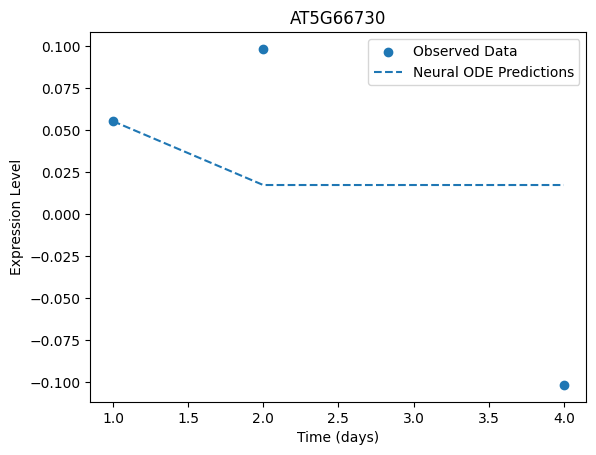

In [ ]:
# Generate predictions
with torch.no_grad():
    y0 = gene_expressions_tensor[:, 0].unsqueeze(0)  # Initial condition
    preds = model(time_points_tensor, y0).squeeze(0).numpy()  # Shape: (n_time_points, n_genes)
    preds = preds.reshape(preds.shape[0],-1) # Reshape preds

# Plot the results
for i, gene_id in enumerate(df["Gene"]):
    plt.figure()
    plt.scatter(time_points, gene_expressions[i], label="Observed Data")
    plt.plot(time_points, preds[:, i], label="Neural ODE Predictions", linestyle="--")  # Access predictions for the current gene
    plt.title(gene_id)
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load the data
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864]
}
df = pd.DataFrame(data)

# Extract time points and gene expression data (row-wise)
time_points = np.array([1.0, 2.0, 4.0])  # Days 1, 2, 4
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (4 genes, 3 time points)

# Convert to PyTorch tensors (each row is a separate time series)
time_points_tensor = torch.tensor(time_points, dtype=torch.float32)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)  # Shape: (4, 3)

In [ ]:
time_points_tensor

tensor([1., 2., 4.])

In [ ]:
gene_data_tensor

tensor([[-0.4480, -0.5602, -5.0920],
        [ 1.7784,  0.0000,  0.0000],
        [ 0.0000,  1.1751,  0.0000],
        [ 0.0554,  0.0984, -0.1018]])

In [ ]:
class GeneSpecificODE(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a simple network for a single gene's dynamics
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # Input: time (scalar), Output: hidden state
            nn.Tanh(),
            nn.Linear(16, 1)    # Output: derivative of the gene's expression
        )

    def forward(self, t, y):
        # y: (batch_size, 1) = current gene expression
        # t: scalar
        t_tensor = torch.ones_like(y) * t  # Shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)  # Compute derivative
        return dy_dt

# Initialize one ODE model per gene
n_genes = gene_data.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(n_genes)])

In [ ]:
def inverse_pinn_loss(ode_models, time_points, gene_data):
    total_loss = 0.0
    for i in range(n_genes):
        # Extract data for the i-th gene
        y_true = gene_data[i].unsqueeze(-1)  # Shape: (3, 1)

        # Initial condition (expression at t=1d)
        y0 = y_true[0].unsqueeze(0)  # Shape: (1, 1)

        # Solve the ODE for the i-th gene
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # Shape: (3,)

        # Compute MSE loss for this gene
        loss = torch.mean((preds - y_true.squeeze()) ** 2)
        total_loss += loss

    return total_loss / n_genes  # Average loss across genes

In [ ]:
optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 3.0723
Epoch 100, Loss: 0.0795
Epoch 200, Loss: 0.0030
Epoch 300, Loss: 0.0000
Epoch 400, Loss: 0.0000
Epoch 500, Loss: 0.0000
Epoch 600, Loss: 0.0000
Epoch 700, Loss: 0.0000
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000


In [ ]:
# gene_data

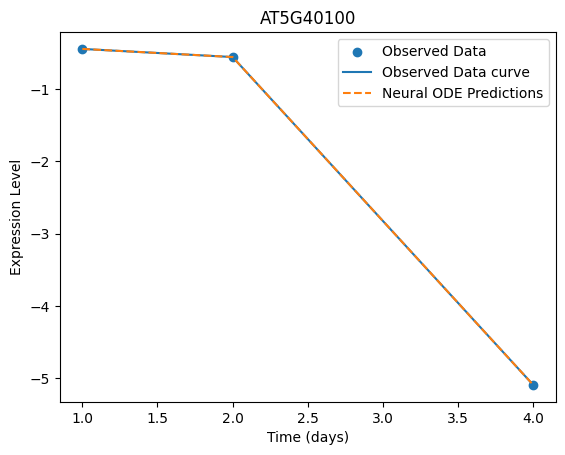

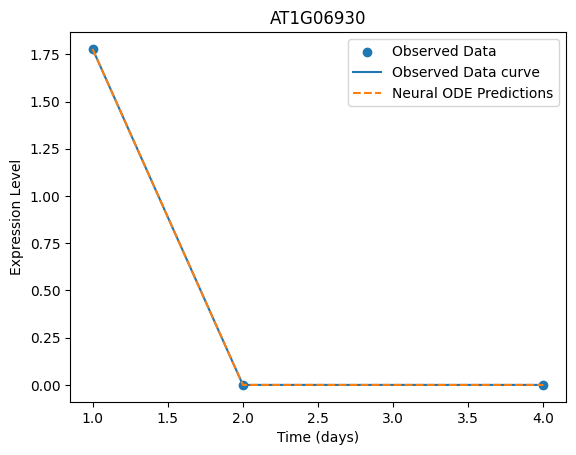

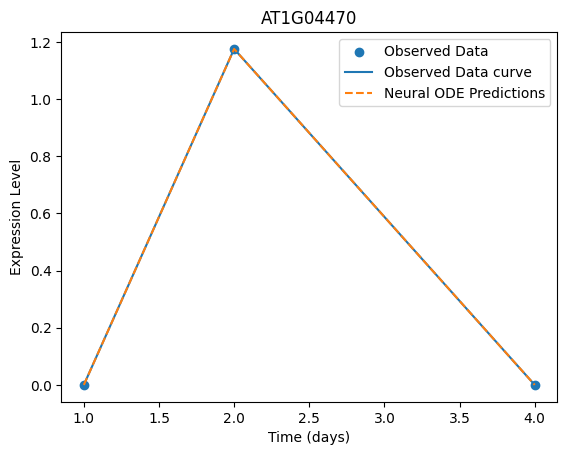

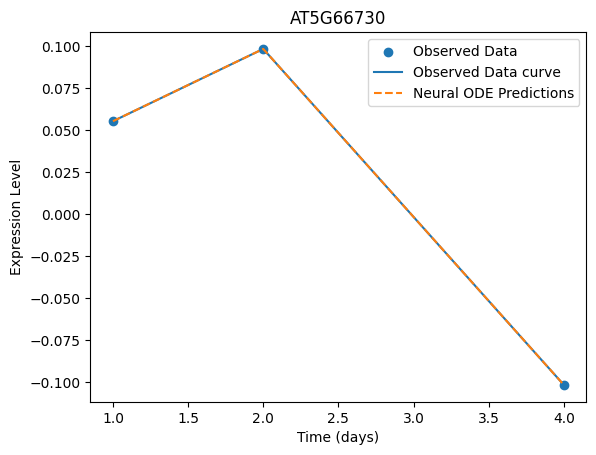

In [ ]:
with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        # Initial condition (t=1d)
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)

        # Solve the ODE
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot
        plt.figure()
        plt.scatter(time_points, gene_data[i], label="Observed Data")
        plt.plot(time_points, gene_data[i], label="Observed Data curve")

        plt.plot(time_points, preds, label="Neural ODE Predictions", linestyle="--")
        plt.title(gene_id)
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

In [ ]:
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    W1 = model.net[0].weight.detach().numpy().flatten()  # Input layer weights
    b1 = model.net[0].bias.detach().numpy().flatten()    # Input layer bias
    W2 = model.net[2].weight.detach().numpy().flatten()  # Output layer weights
    b2 = model.net[2].bias.detach().numpy().flatten()    # Output layer bias

    # ODE equation: dy/dt = W2 * tanh(W1 * t + b1) + b2
    equation = f"d{gene_id}/dt = "
    equation += f"{W2[0]:.4f} * tanh("
    equation += " + ".join([f"{w:.4f}·t" for w in W1]) + f" + {b1[0]:.4f}) + {b2[0]:.4f}"
    print(equation + "\n")

dAT5G40100/dt = 0.2329 * tanh(-0.1934·t + 0.6486·t + 0.7562·t + 0.5088·t + 0.5543·t + -0.5536·t + 0.6112·t + 0.3471·t + -0.4783·t + -0.3677·t + -0.3619·t + -0.6237·t + -0.7028·t + 0.4172·t + 0.5348·t + -0.2564·t + -0.5644) + -0.1312

dAT1G06930/dt = -0.1602 * tanh(-0.2760·t + -0.6648·t + -0.8428·t + 0.2489·t + 0.3286·t + -0.4444·t + 1.2444·t + 0.4069·t + -0.2443·t + -0.4314·t + -0.2046·t + -0.9493·t + -0.3658·t + 0.8558·t + -1.4115·t + -0.6800·t + 0.1391) + 0.1365

dAT1G04470/dt = -0.6214 * tanh(0.5045·t + -1.1032·t + -0.6437·t + -0.3443·t + -0.3392·t + 0.5036·t + -0.2490·t + -0.7238·t + -0.1417·t + -0.3800·t + 0.2033·t + 0.6395·t + -0.8163·t + 1.2088·t + 0.4756·t + -0.4486·t + -1.0282) + 0.1083

dAT5G66730/dt = -0.0427 * tanh(-0.8022·t + -0.1732·t + -0.1970·t + -0.4797·t + -0.4162·t + -0.0448·t + -0.7275·t + 0.6577·t + -0.5564·t + -0.7377·t + 0.3261·t + 0.3654·t + -0.6741·t + -0.5012·t + 0.1959·t + -0.0974·t + 0.1975) + -0.2321



In [ ]:
# Use the trained model to predict gene expressions at [1d, 2d, 4d]
with torch.no_grad():
    predictions = []
    for i in range(n_genes):
        # Initial condition (expression at t=1d)
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)
        # Solve the ODE for the i-th gene
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        predictions.append(preds)

# Convert to numpy array
predictions = np.array(predictions)  # Shape: (4 genes, 3 time points)

# Calculate MSE for each gene
mse = np.mean((predictions - gene_data) ** 2, axis=1)
print("Mean Squared Error (MSE) for each gene:")
for i, gene_id in enumerate(df["Gene"]):
    print(f"{gene_id}: {mse[i]:.4e}")

Mean Squared Error (MSE) for each gene:
AT5G40100: 3.6629e-12
AT1G06930: 1.0545e-15
AT1G04470: 1.5724e-12
AT5G66730: 8.8732e-19


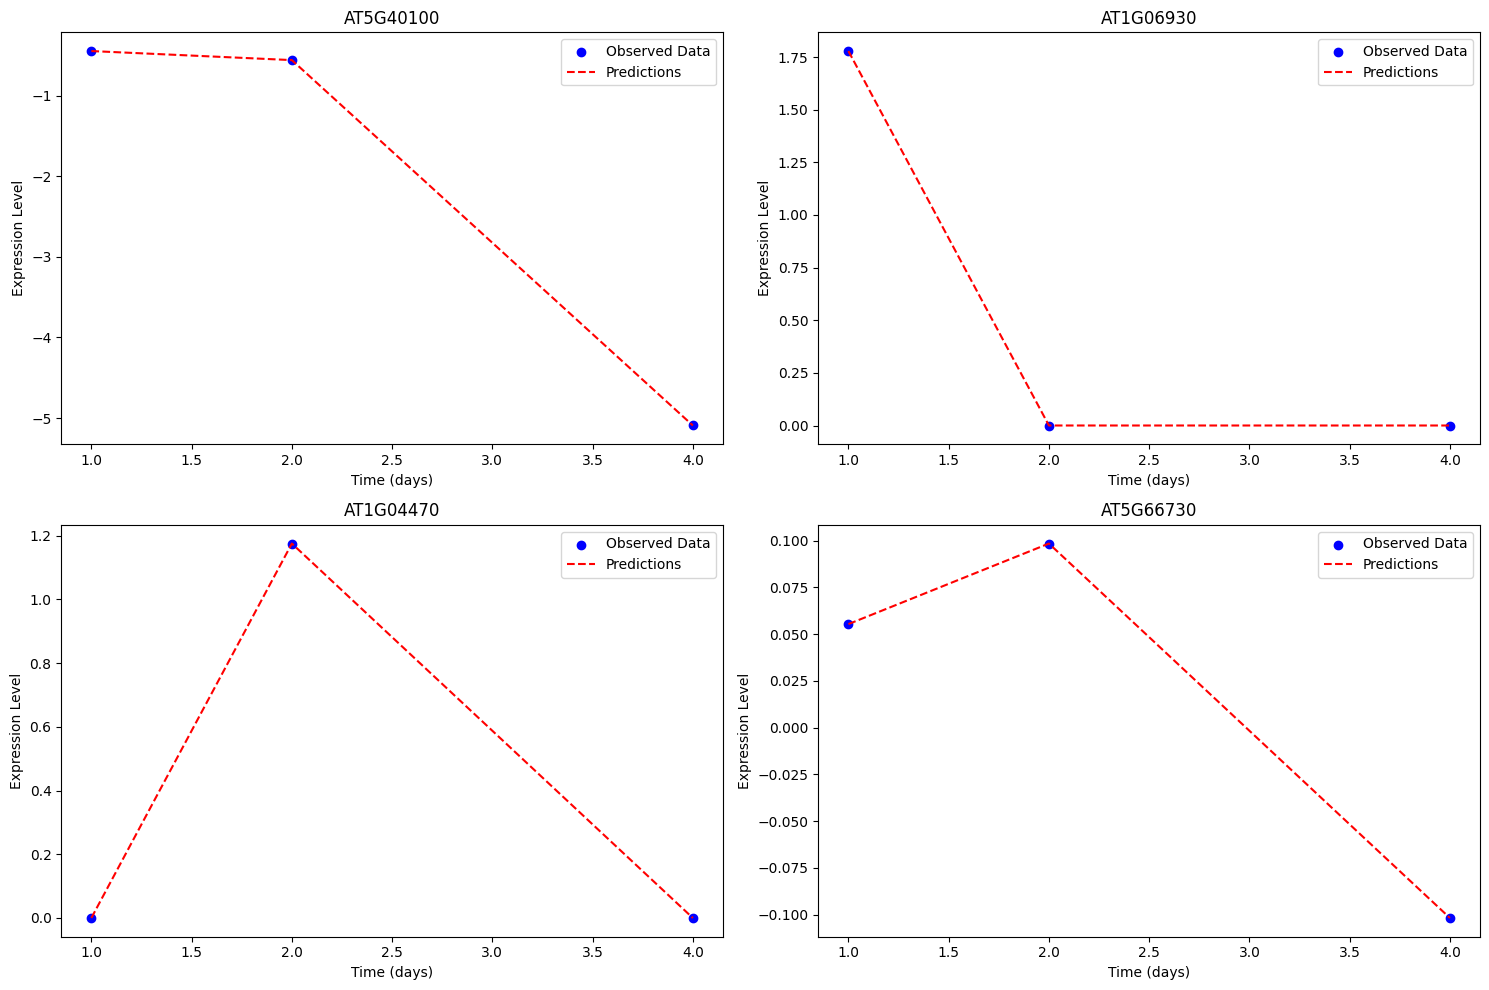

In [ ]:
plt.figure(figsize=(15, 10))
for i, gene_id in enumerate(df["Gene"]):
    plt.subplot(2, 2, i+1)
    plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
    plt.plot(time_points, predictions[i], 'r--', label="Predictions")
    plt.title(gene_id)
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
plt.tight_layout()
plt.show()

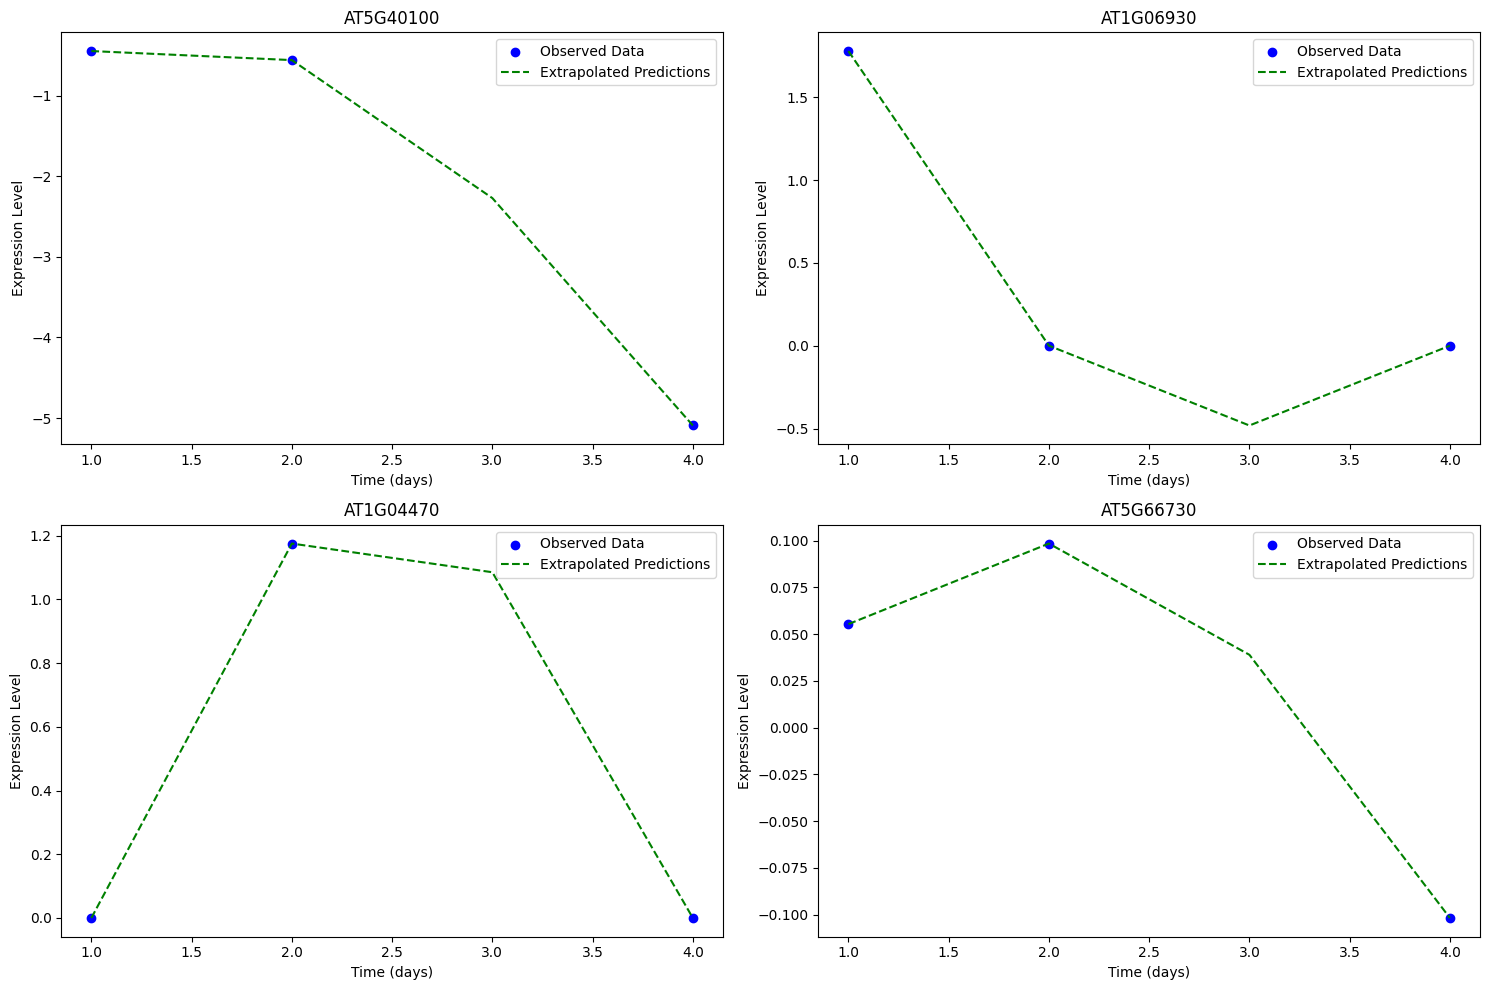

In [ ]:
# Define new time points including t=3d
new_time_points = torch.tensor([1.0, 2.0, 3.0, 4.0], dtype=torch.float32)

# Generate predictions for new time points
with torch.no_grad():
    extrapolated_predictions = []
    for i in range(n_genes):
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)
        preds = odeint(ode_models[i], y0, new_time_points).squeeze().numpy()
        extrapolated_predictions.append(preds)

# Plot extrapolation results
plt.figure(figsize=(15, 10))
for i, gene_id in enumerate(df["Gene"]):
    plt.subplot(2, 2, i+1)
    plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
    plt.plot(new_time_points, extrapolated_predictions[i], 'g--', label="Extrapolated Predictions")
    plt.title(gene_id)
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("\nLearned ODE Equations:")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    W1 = model.net[0].weight.detach().numpy().flatten()
    b1 = model.net[0].bias.detach().numpy().flatten()
    W2 = model.net[2].weight.detach().numpy().flatten()
    b2 = model.net[2].bias.detach().numpy().flatten()

    equation = f"d{gene_id}/dt = "
    equation += f"{W2[0]:.4f} * tanh("
    equation += " + ".join([f"{w:.4f}·t" for w in W1]) + f" + {b1[0]:.4f}) + {b2[0]:.4f}"
    print(equation + "\n")


Learned ODE Equations:
dAT5G40100/dt = 0.2329 * tanh(-0.1934·t + 0.6486·t + 0.7562·t + 0.5088·t + 0.5543·t + -0.5536·t + 0.6112·t + 0.3471·t + -0.4783·t + -0.3677·t + -0.3619·t + -0.6237·t + -0.7028·t + 0.4172·t + 0.5348·t + -0.2564·t + -0.5644) + -0.1312

dAT1G06930/dt = -0.1602 * tanh(-0.2760·t + -0.6648·t + -0.8428·t + 0.2489·t + 0.3286·t + -0.4444·t + 1.2444·t + 0.4069·t + -0.2443·t + -0.4314·t + -0.2046·t + -0.9493·t + -0.3658·t + 0.8558·t + -1.4115·t + -0.6800·t + 0.1391) + 0.1365

dAT1G04470/dt = -0.6214 * tanh(0.5045·t + -1.1032·t + -0.6437·t + -0.3443·t + -0.3392·t + 0.5036·t + -0.2490·t + -0.7238·t + -0.1417·t + -0.3800·t + 0.2033·t + 0.6395·t + -0.8163·t + 1.2088·t + 0.4756·t + -0.4486·t + -1.0282) + 0.1083

dAT5G66730/dt = -0.0427 * tanh(-0.8022·t + -0.1732·t + -0.1970·t + -0.4797·t + -0.4162·t + -0.0448·t + -0.7275·t + 0.6577·t + -0.5564·t + -0.7377·t + 0.3261·t + 0.3654·t + -0.6741·t + -0.5012·t + 0.1959·t + -0.0974·t + 0.1975) + -0.2321



Epoch 0, Loss: 3.8583
Epoch 100, Loss: 0.2189
Epoch 200, Loss: 0.1329
Epoch 300, Loss: 0.0721


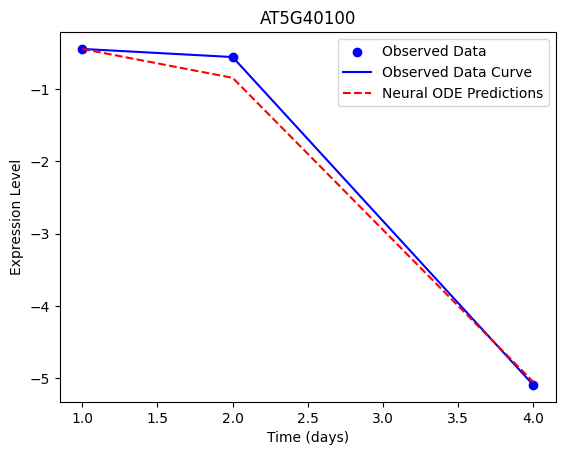

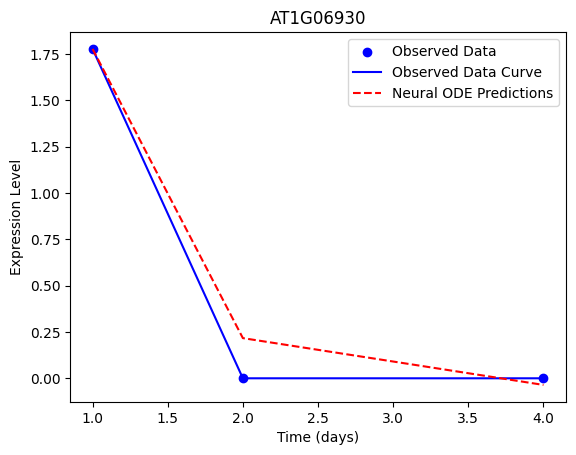

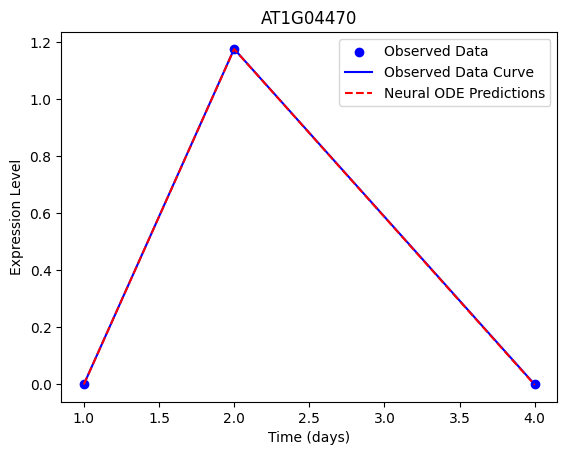

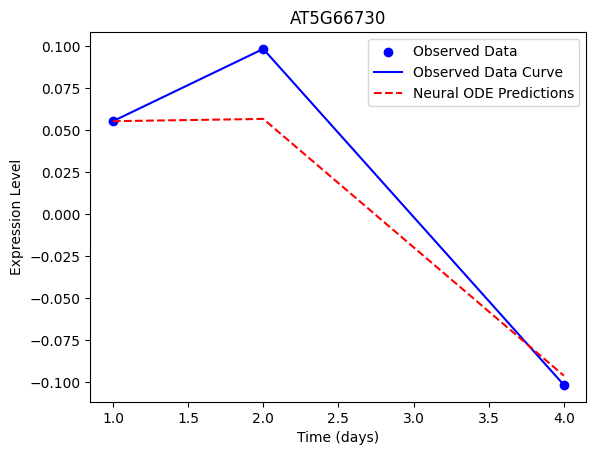


Learned ODE Equations:
dAT5G40100/dt = 0.1591 * tanh(-0.3148·t + -0.5889·t + 0.3987·t + 0.3112·t + 0.2756·t + -0.6294·t + 0.6186·t + -0.3345·t + 0.4698·t + -0.3043·t + 0.2520·t + 0.5392·t + 0.3014·t + -0.0272·t + 0.3924·t + -0.3475·t + 0.3379) + 0.0420

dAT1G06930/dt = -0.9991 * tanh(-1.6102·t + 3.1986·t + 2.6705·t + 1.0606·t + 0.7737·t + 0.0999·t + 0.2629·t + 0.2525·t + -1.5795·t + -0.7045·t + 0.2045·t + 0.2170·t + 0.3227·t + -0.2709·t + 1.6805·t + -1.0116·t + 3.7969) + 0.2140

dAT1G04470/dt = -0.1864 * tanh(1.5319·t + 0.2496·t + -1.4900·t + 1.8836·t + 1.1401·t + -0.4629·t + -0.2600·t + 2.5484·t + -0.1831·t + 1.8259·t + 0.9859·t + -1.6814·t + 0.6368·t + 0.3062·t + 0.3571·t + 0.2622·t + 1.6631) + -0.3534

dAT5G66730/dt = 0.1890 * tanh(-0.2906·t + 0.8977·t + 0.3568·t + 0.0511·t + 0.7729·t + 0.6719·t + 0.0623·t + 0.1770·t + -0.2277·t + -0.6943·t + -0.7312·t + -0.4517·t + 0.2412·t + 0.5427·t + 0.2344·t + 0.8043·t + -0.0920) + -0.0781



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load the data
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864]
}
df = pd.DataFrame(data)

# Extract time points and gene expression data (row-wise)
time_points = np.array([1.0, 2.0, 4.0])  # Days 1, 2, 4
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (4 genes, 3 time points)

# Convert to PyTorch tensors (each row is a separate time series)
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)  # Enable gradients
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)  # Shape: (4, 3)

class GeneSpecificODE(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a simple network for a single gene's dynamics
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # Input: time (scalar), Output: hidden state
            nn.Tanh(),
            nn.Linear(16, 1)    # Output: derivative of the gene's expression
        )

    def forward(self, t, y):
        # y: (batch_size, 1) = current gene expression
        # t: scalar
        t_tensor = torch.ones_like(y) * t  # Shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)  # Compute derivative
        return dy_dt

# Initialize one ODE model per gene
n_genes = gene_data.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(n_genes)])

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_loss = 0.0
    for i in range(n_genes):
        # Extract data for the i-th gene
        y_true = gene_data[i].unsqueeze(-1)  # Shape: (3, 1)

        # Initial condition (expression at t=1d)
        y0 = y_true[0].unsqueeze(0)  # Shape: (1, 1)

        # Solve the ODE for the i-th gene
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # Shape: (3,)

        # Data loss (MSE between predictions and observed data)
        data_loss = torch.mean((preds - y_true.squeeze()) ** 2)

        # Physics loss (ODE consistency)
        # Compute dy/dt from the predictions using autograd
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        # Compute dy/dt from the ODE function
        dy_dt_ode = torch.stack([ode_models[i](t, p.unsqueeze(0)) for t, p in zip(time_points, preds)]).squeeze()

        # Physics loss (MSE between predicted and ODE-computed derivatives)
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        # Total loss
        total_loss += data_loss + lambda_physics * physics_loss

    return total_loss / n_genes  # Average loss across genes

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 400

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Generate predictions and plot results
with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        # Initial condition (t=1d)
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)

        # Solve the ODE
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Data Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Predictions")
        plt.title(gene_id)
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

# Print learned ODE equations
print("\nLearned ODE Equations:")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    W1 = model.net[0].weight.detach().numpy().flatten()  # Input layer weights
    b1 = model.net[0].bias.detach().numpy().flatten()    # Input layer bias
    W2 = model.net[2].weight.detach().numpy().flatten()  # Output layer weights
    b2 = model.net[2].bias.detach().numpy().flatten()    # Output layer bias

    # ODE equation: dy/dt = W2 * tanh(W1 * t + b1) + b2
    equation = f"d{gene_id}/dt = "
    equation += f"{W2[0]:.4f} * tanh("
    equation += " + ".join([f"{w:.4f}·t" for w in W1]) + f" + {b1[0]:.4f}) + {b2[0]:.4f}"
    print(equation + "\n")

Epoch    0 | Total Loss: 2.6960 | Data Loss: 2.6858 | Physics Loss: 0.1020
Epoch  100 | Total Loss: 0.2123 | Data Loss: 0.1554 | Physics Loss: 0.5686
Epoch  200 | Total Loss: 0.1577 | Data Loss: 0.1154 | Physics Loss: 0.4230
Epoch  300 | Total Loss: 0.0724 | Data Loss: 0.0540 | Physics Loss: 0.1845
Epoch  400 | Total Loss: 0.0232 | Data Loss: 0.0168 | Physics Loss: 0.0633
Epoch  500 | Total Loss: 0.0097 | Data Loss: 0.0065 | Physics Loss: 0.0313
Epoch  600 | Total Loss: 0.0080 | Data Loss: 0.0053 | Physics Loss: 0.0271
Epoch  700 | Total Loss: 0.0072 | Data Loss: 0.0048 | Physics Loss: 0.0247
Epoch  800 | Total Loss: 0.0084 | Data Loss: 0.0056 | Physics Loss: 0.0276
Epoch  900 | Total Loss: 0.1088 | Data Loss: 0.0096 | Physics Loss: 0.9917


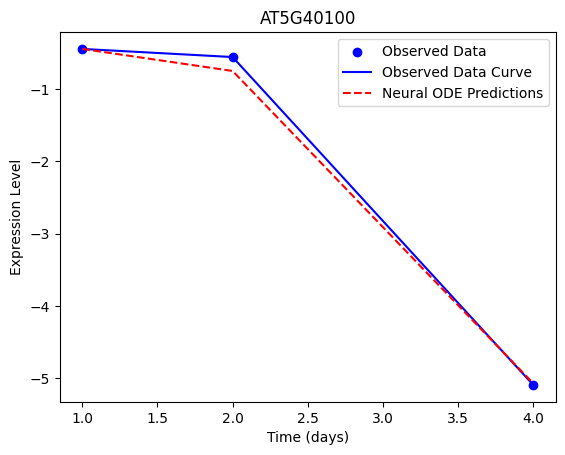

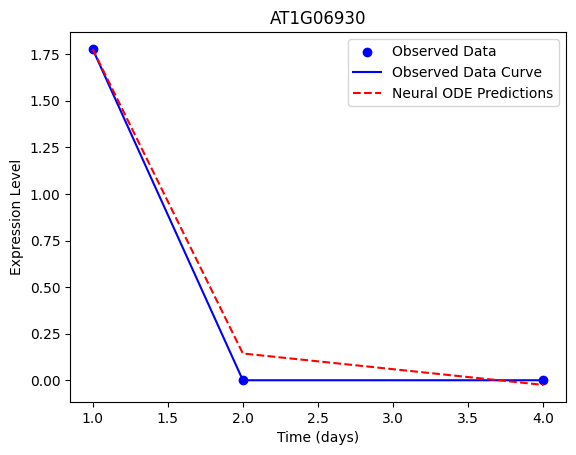

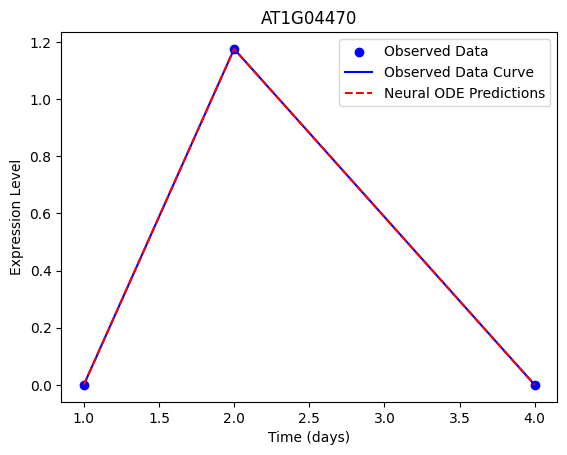

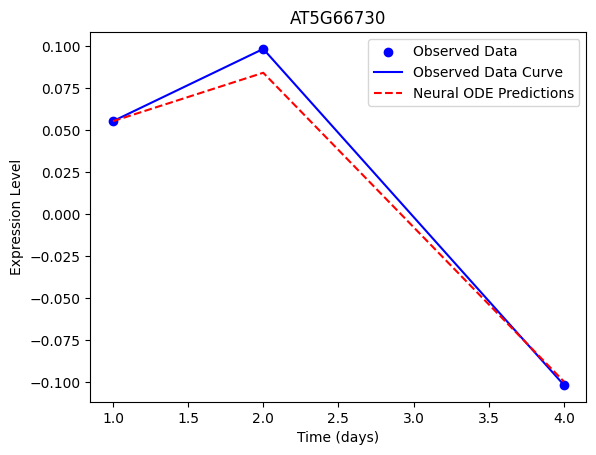


Learned ODE Parameters and Equations:
Gene: AT5G40100
  net.0.weight: tensor([[ 0.5369],
        [ 0.9290],
        [-0.1814],
        [ 0.0860],
        [ 0.1491],
        [ 0.4530],
        [-0.5598],
        [-0.0772],
        [-0.2742],
        [ 0.4624],
        [-0.1560],
        [-0.2988],
        [-0.2066],
        [ 0.5161],
        [-0.1578],
        [-0.2170]])
  net.0.bias: tensor([-0.0301, -2.4721, -1.2868,  1.5901,  0.4114, -1.2127,  1.5233, -1.4654,
         0.7145, -1.2395, -0.5311,  0.6420,  0.2565, -1.3886, -0.5740,  0.2049])
  net.2.weight: tensor([[ 0.0405, -0.4707,  0.3957, -0.2042, -0.1489, -0.3726,  0.2735,  0.1668,
          0.0687, -0.4143,  0.3328,  0.4306,  0.2496, -0.2545,  0.3002,  0.4356]])
  net.2.bias: tensor([-0.2050])
  dAT5G40100/dt = 0.0405 * tanh(0.5369·t + 0.9290·t + -0.1814·t + 0.0860·t + 0.1491·t + 0.4530·t + -0.5598·t + -0.0772·t + -0.2742·t + 0.4624·t + -0.1560·t + -0.2988·t + -0.2066·t + 0.5161·t + -0.1578·t + -0.2170·t + -0.0301) + -0.2050



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load the data
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864]
}
df = pd.DataFrame(data)

# Extract time points and gene expression data (row-wise)
time_points = np.array([1.0, 2.0, 4.0])  # Days 1, 2, 4
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (4 genes, 3 time points)

# Convert to PyTorch tensors (each row is a separate time series)
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)  # Shape: (4, 3)

class GeneSpecificODE(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a simple network for a single gene's dynamics
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # Input: time (scalar), Output: hidden state
            nn.Tanh(),
            nn.Linear(16, 1)    # Output: derivative of the gene's expression
        )

    def forward(self, t, y):
        # y: (batch_size, 1) = current gene expression
        # t: scalar
        t_tensor = torch.ones_like(y) * t  # Shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)  # Compute derivative
        return dy_dt

# Initialize one ODE model per gene
n_genes = gene_data.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(n_genes)])

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    for i in range(n_genes):
        # Extract data for the i-th gene (shape: (3, 1))
        y_true = gene_data[i].unsqueeze(-1)

        # Initial condition (expression at t=1d)
        y0 = y_true[0].unsqueeze(0)

        # Solve the ODE for the i-th gene
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # Shape: (3,)

        # Data loss (MSE between predictions and observed data)
        data_loss = torch.mean((preds - y_true.squeeze()) ** 2)

        # Physics loss (ODE consistency)
        # Compute derivative of predictions using autograd
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        # Compute derivative using the ODE function (neural network output)
        dy_dt_ode = torch.stack([ode_models[i](t, p.unsqueeze(0)) for t, p in zip(time_points, preds)]).squeeze()

        # Physics loss (MSE between the two derivatives)
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 1000

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

# Generate predictions and plot results
with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        # Initial condition (t=1d)
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)

        # Solve the ODE
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data and predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Data Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Predictions")
        plt.title(gene_id)
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

# Print learned ODE parameters and equations for each gene
print("\nLearned ODE Parameters and Equations:")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    print(f"Gene: {gene_id}")
    # Print each parameter (weights and biases)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  {name}: {param.data}")

    # Extract parameters for the ODE equation from the network
    W1 = model.net[0].weight.detach().numpy().flatten()  # Weights from input layer
    b1 = model.net[0].bias.detach().numpy().flatten()      # Bias from input layer
    W2 = model.net[2].weight.detach().numpy().flatten()     # Weights from output layer
    b2 = model.net[2].bias.detach().numpy().flatten()       # Bias from output layer

    # Construct and print the ODE equation:
    # d(expression)/dt = W2 * tanh(W1 * t + b1) + b2
    equation = f"d{gene_id}/dt = {W2[0]:.4f} * tanh(" + " + ".join([f"{w:.4f}·t" for w in W1]) + f" + {b1[0]:.4f}) + {b2[0]:.4f}"
    print("  " + equation + "\n")


In [ ]:
ode_models.parameters

<bound method Module.parameters of ModuleList(
  (0-5): 6 x GeneSpecificODE(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)>

Original Data:
        Gene  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38471   0.505000   0.505000   0.505000
5  AT2G38472   0.900000   0.500000   0.000000

Predictions for AT5G40100 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: -0.4480
  Time 3.0d: -0.9620
  Time 5.0d: -1.5554


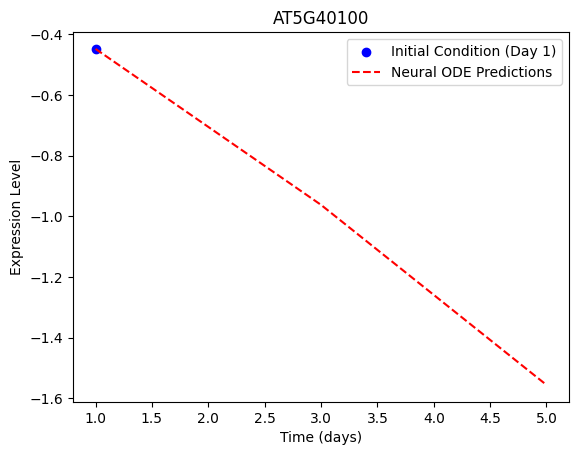


Predictions for AT1G06930 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 1.7784
  Time 3.0d: 1.7056
  Time 5.0d: 1.7335


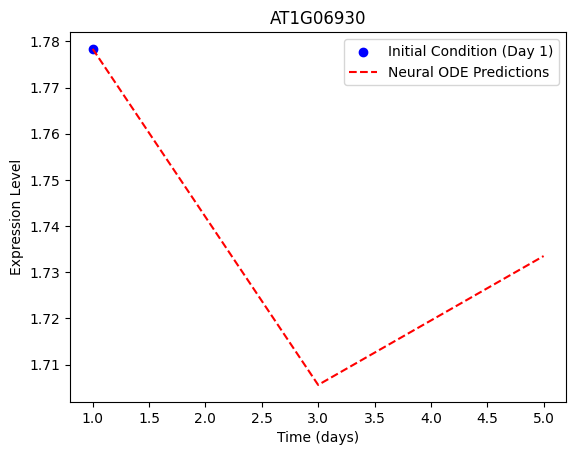


Predictions for AT1G04470 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 0.0000
  Time 3.0d: 0.7091
  Time 5.0d: 1.3562


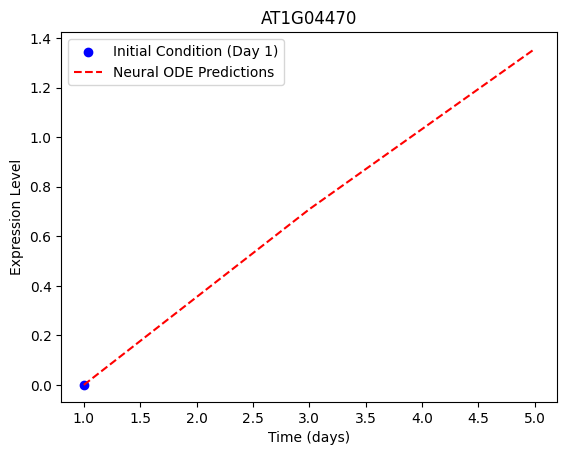


Predictions for AT5G66730 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 0.0554
  Time 3.0d: 0.0849
  Time 5.0d: -0.0213


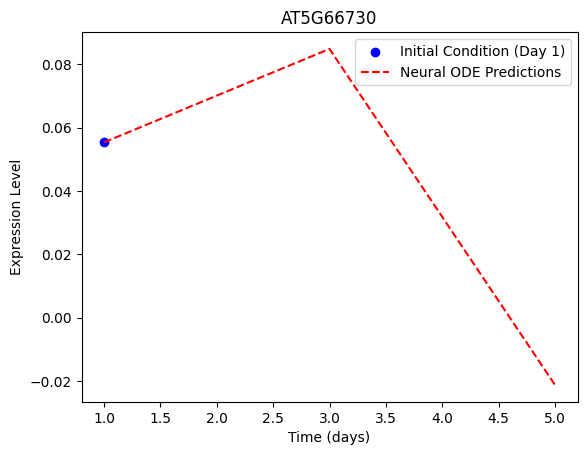


Predictions for AT2G38471 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 0.5050
  Time 3.0d: -0.6515
  Time 5.0d: -2.3920


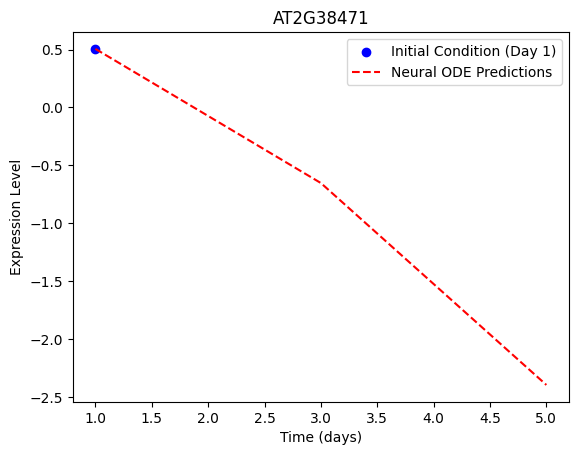


Predictions for AT2G38472 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 0.9000
  Time 3.0d: 0.1663
  Time 5.0d: -0.7837


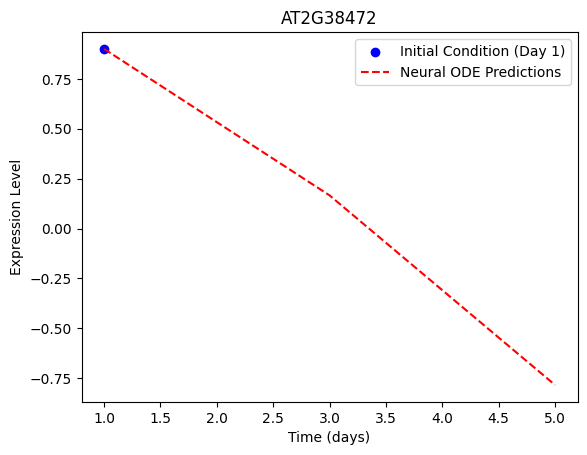

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Create a dataset with 6 genes (for illustration)
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38471", "AT2G38472"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646, 0.505, 0.9],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984, 0.505, 0.5],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864, 0.505, 0]
}
df = pd.DataFrame(data)

# Print the original dataset
print("Original Data:")
print(df)

# Use the training dataset's time points (days 1, 2, 4) for reference
train_time_points = np.array([1.0, 2.0, 4.0])
# For testing, define a new set of time points (for example, days 1, 3, 5)
test_time_points = np.array([1.0, 3.0, 5.0])

# Extract gene expression data (rows: genes, columns: time points)
# Here the first column (day 1) will be used as the initial condition.
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (6, 3)

# Convert test time points and gene data to PyTorch tensors
test_time_points_tensor = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)  # Shape: (6, 3)

# Define the Neural ODE model for a single gene
class GeneSpecificODE(nn.Module):
    def __init__(self):
        super().__init__()
        # A simple network that takes time as input and outputs the derivative dy/dt
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, t, y):
        # Here, we create a tensor with the same shape as y filled with the scalar t.
        t_tensor = torch.ones_like(y) * t
        dy_dt = self.net(t_tensor)
        return dy_dt

# Create one pre-trained ODE model per gene.
# (In practice, you would load the model parameters from saved files.)
n_genes = gene_data.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(n_genes)])
# For demonstration, we assume the models are pre-trained.
# Example:
# for i, model in enumerate(ode_models):
#     model.load_state_dict(torch.load(f"gene_{i}_model.pth"))

# Use the trained model to predict the test dataset results.
# For each gene, use the expression value at day 1 as the initial condition.
with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        # Use the training data's day-1 value as the initial condition.
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)  # Shape: (1, 1)

        # Solve the ODE over the test time grid.
        preds = odeint(ode_models[i], y0, test_time_points_tensor).squeeze().numpy()

        # Print predictions for each gene.
        print(f"\nPredictions for {gene_id} on test dataset (time points {test_time_points}):")
        for t, pred in zip(test_time_points, preds):
            print(f"  Time {t:.1f}d: {pred:.4f}")

        # Plot observed initial condition and predicted time series.
        plt.figure()
        plt.scatter([1.0], [gene_data[i, 0]], c='b', label="Initial Condition (Day 1)")
        plt.plot(test_time_points, preds, 'r--', label="Neural ODE Predictions")
        plt.title(gene_id)
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()


Original Data:
        Gene  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38471   0.505000   0.505000   0.505000
5  AT2G38472   0.900000   0.500000   0.000000

Predictions for AT5G40100 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: -0.4480
  Time 3.0d: -0.4978
  Time 5.0d: -0.3761


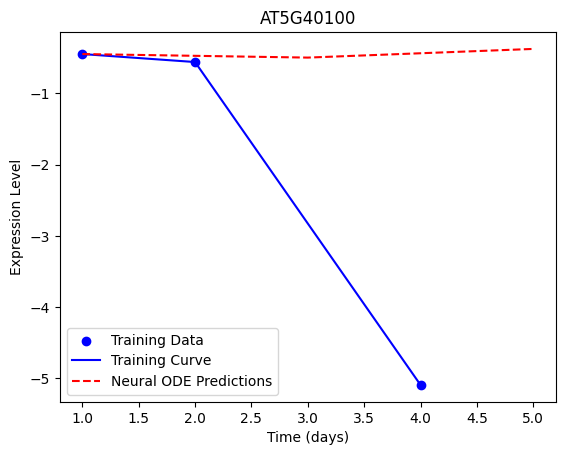


Predictions for AT1G06930 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 1.7784
  Time 3.0d: 0.7826
  Time 5.0d: 0.2443


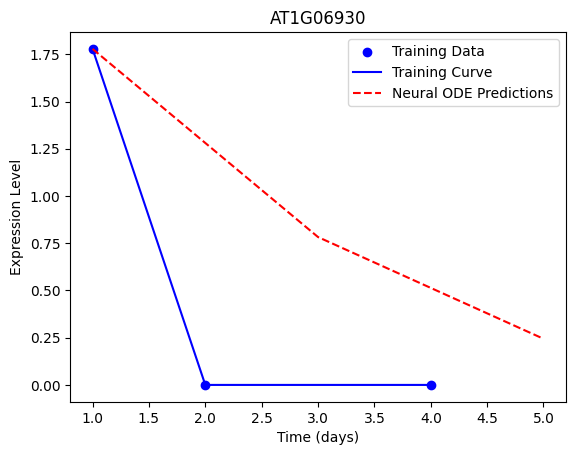


Predictions for AT1G04470 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 0.0000
  Time 3.0d: 1.3232
  Time 5.0d: 2.7672


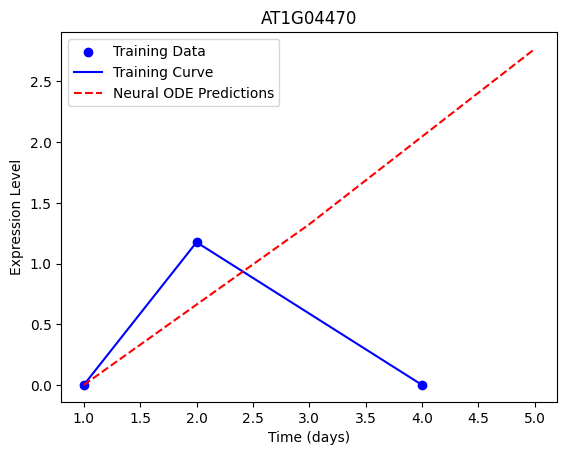


Predictions for AT5G66730 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 0.0554
  Time 3.0d: 1.2176
  Time 5.0d: 2.6703


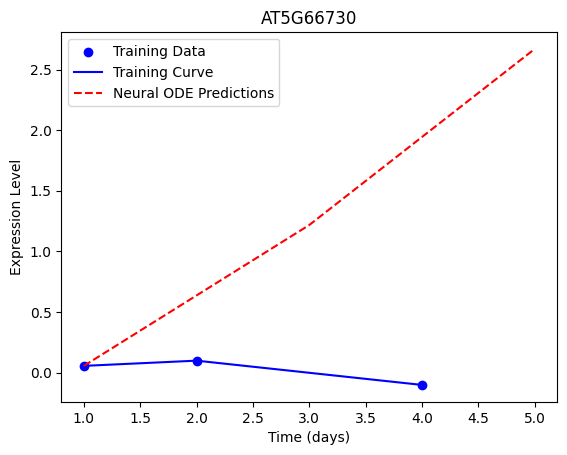


Predictions for AT2G38471 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 0.5050
  Time 3.0d: 1.2763
  Time 5.0d: 2.0810


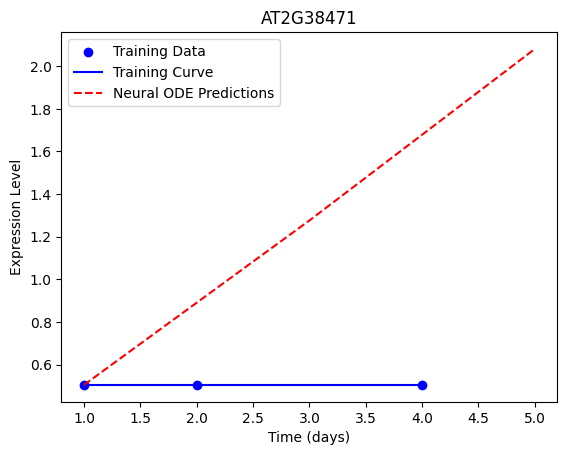


Predictions for AT2G38472 on test dataset (time points [1. 3. 5.]):
  Time 1.0d: 0.9000
  Time 3.0d: 2.3129
  Time 5.0d: 4.4612


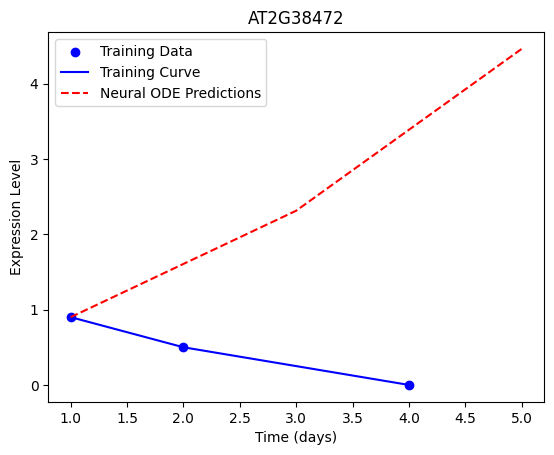

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Create a dataset with 6 genes (for illustration)
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38471", "AT2G38472"],
    "Hpa-NO_1d": [-0.44796003, 1.778358524, 0, 0.055374646, 0.505, 0.9],
    "Hpa-NO_2d": [-0.560154646, 0, 1.175149691, 0.098434984, 0.505, 0.5],
    "Hpa-NO_4d": [-5.091964284, 0, 0, -0.101756864, 0.505, 0]
}
df = pd.DataFrame(data)

# Print the original dataset
print("Original Data:")
print(df)

# Use the training dataset's time points (days 1, 2, 4)
train_time_points = np.array([1.0, 2.0, 4.0])
# For testing, define a new set of time points (for example, days 1, 3, 5)
test_time_points = np.array([1.0, 3.0, 5.0])

# Extract gene expression data (rows: genes, columns: time points)
# Here the first column (day 1) will be used as the initial condition.
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values  # Shape: (6, 3)

# Convert test time points and gene data to PyTorch tensors
test_time_points_tensor = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)  # Shape: (6, 3)

# Define the Neural ODE model for a single gene
class GeneSpecificODE(nn.Module):
    def __init__(self):
        super().__init__()
        # A simple network that takes time as input and outputs the derivative dy/dt
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, t, y):
        # Create a tensor with the same shape as y filled with the scalar t.
        t_tensor = torch.ones_like(y) * t
        dy_dt = self.net(t_tensor)
        return dy_dt

# Create one pre-trained ODE model per gene.
# (In practice, you would load the model parameters from saved files.)
n_genes = gene_data.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(n_genes)])
# For demonstration, we assume the models are pre-trained.
# Example:
# for i, model in enumerate(ode_models):
#     model.load_state_dict(torch.load(f"gene_{i}_model.pth"))

# Use the trained model to predict the test dataset results.
# For each gene, use the expression value at day 1 as the initial condition.
with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        # Use the training data's day-1 value as the initial condition.
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)  # Shape: (1, 1)

        # Solve the ODE over the test time grid.
        preds = odeint(ode_models[i], y0, test_time_points_tensor).squeeze().numpy()

        # Print predictions for each gene.
        print(f"\nPredictions for {gene_id} on test dataset (time points {test_time_points}):")
        for t, pred in zip(test_time_points, preds):
            print(f"  Time {t:.1f}d: {pred:.4f}")

        # Plot observed data (training points) and predicted time series.
        plt.figure()
        # Plot training data points from train_time_points
        plt.scatter(train_time_points, gene_data[i], c='b', label="Training Data")
        plt.plot(train_time_points, gene_data[i], 'b-', label="Training Curve")
        # Plot predictions on the test time grid
        plt.plot(test_time_points, preds, 'r--', label="Neural ODE Predictions")
        plt.title(gene_id)
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()


In [5]:
!pip install torchdiffeq --force-reinstall  # force-reinstall to pick up potential fixes
!pip install torch --upgrade --force-reinstall  # upgrade torch and force-reinstall to pick up fixes

import torch
import torch.nn as nn
import torch.optim as optim
# ... (your other imports and code)

# Turn off torch.compile for now
torch._dynamo.config.suppress_errors = True
# ... (your optimizer initialization and other code)

  Using cached torchdiffeq-0.2.5-py3-none-any.whl.metadata (440 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1

  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Usin

ImportError: cannot import name 'TensorifyScalarRestartAnalysis' from 'torch._dynamo.exc' (/usr/local/lib/python3.11/dist-packages/torch/_dynamo/exc.py)

Epoch    0 | Total Loss: 1.7520 | Data Loss: 1.7124 | Physics Loss: 0.3968
Epoch  100 | Total Loss: 0.2053 | Data Loss: 0.1464 | Physics Loss: 0.5886
Epoch  200 | Total Loss: 0.1078 | Data Loss: 0.0777 | Physics Loss: 0.3014


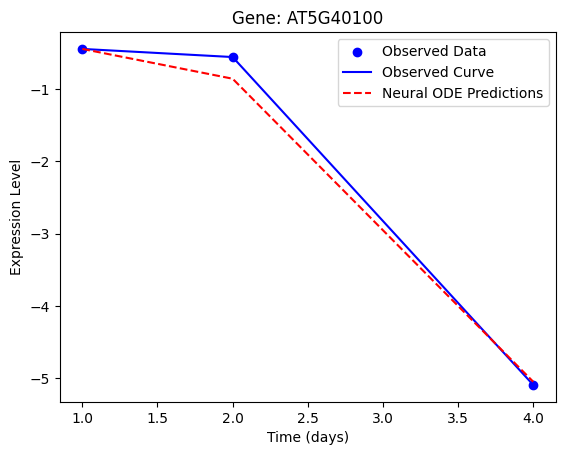

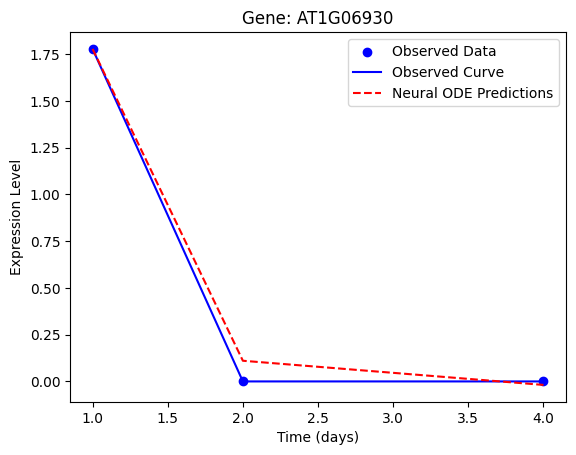

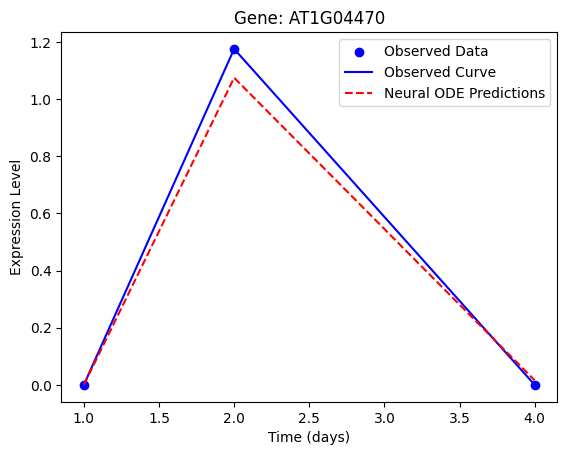

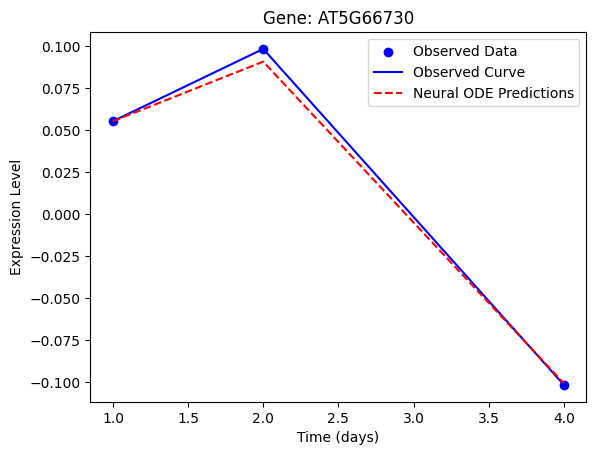


Learned ODE Parameters and Equations:
Gene: AT5G40100
  net.0.weight: tensor([[-0.5111],
        [ 0.6232],
        [-0.3794],
        [-0.3356],
        [-0.4229],
        [-0.3567],
        [ 0.0955],
        [-0.6109],
        [ 0.2409],
        [-0.2962],
        [-0.4386],
        [-0.4183],
        [-0.5736],
        [ 0.3399],
        [-0.3299],
        [-0.3469]])
  net.0.bias: tensor([ 0.9694,  1.0074,  0.1873,  0.2245, -0.9637,  0.4538,  0.7647,  0.2469,
         0.4909, -0.6348,  0.8141,  0.6663,  1.2783, -0.3535, -0.0894,  0.3258])
  net.2.weight: tensor([[ 0.5240,  0.1118,  0.3515,  0.1822, -0.0631,  0.7004, -0.3048,  0.0387,
          0.1130,  0.2843,  0.1473,  0.3163,  0.4102, -0.1899,  0.2400,  0.1449]])
  net.2.bias: tensor([-0.0701])
  d(AT5G40100)/dt = 0.5240 * tanh(-0.5111 * t + 0.9694) + -0.0701

Gene: AT1G06930
  net.0.weight: tensor([[ 0.2151],
        [-0.3257],
        [-0.3997],
        [ 1.1371],
        [ 0.8304],
        [-1.5329],
        [ 0.2435],
     

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise, Each Column is a Different Day)
##############################################################################

data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Day1":  [-0.44796,    1.77836,     0.0,         0.05537   ],
    "Day2":  [-0.56015,    0.0,         1.17515,     0.09843   ],
    "Day4":  [-5.09196,    0.0,         0.0,        -0.10176   ],
}

df = pd.DataFrame(data)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # day1, day2, day4

# gene_data shape: (num_genes, num_time_points)
gene_data = df[["Day1", "Day2", "Day4"]].values  # 4 genes x 3 time points

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE Model for Each Gene
##############################################################################

class GeneSpecificODE(nn.Module):
    """
    A small neural network that models dY/dt for a single gene as a function of time, t.
    The forward() method returns the derivative dy/dt given (t, y).
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # input: scalar t, output: hidden dimension
            nn.Tanh(),
            nn.Linear(16, 1)   # output: derivative dY/dt
        )

    def forward(self, t, y):
        """
        :param t: current time (scalar)
        :param y: current expression (ignored in this minimal model)
        :return: dy/dt predicted by the neural net
        """
        # For simplicity, we only pass time t into the net (and ignore y).
        # If you want Y dependence, you could concatenate [t, y] as input.
        t_tensor = torch.ones_like(y) * t  # shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)
        return dy_dt


# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(num_genes)])


##############################################################################
# Training Loss Function
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    """
    :param ode_models: list of neural ODE models, one per gene
    :param time_points: tensor of shape (num_time_points,)
    :param gene_data: tensor of shape (num_genes, num_time_points)
    :param lambda_physics: weight for the physics/ODE consistency term
    :return: (total_loss, data_loss, physics_loss)
    """
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_observed = gene_data[i]  # e.g. [-0.45, -0.56, -5.09]

        # The first time point is our "initial condition"
        y0 = y_observed[0].unsqueeze(0)  # shape (1,)

        # odeint() requires an initial condition shape (batch_size,) or (batch_size, dim)
        preds = odeint(ode_models[i], y0, time_points).squeeze()

        # 1) Data loss: MSE between predicted and observed
        data_loss = torch.mean((preds - y_observed) ** 2)

        # 2) Physics loss: measure how consistent the predicted derivative is with the ODE network
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]  # shape: (num_time_points,)

        # Evaluate the ODE derivative from the model
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            # The ODE model expects (t, y) but we're ignoring y in forward()
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes

    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss


##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 300

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Total Loss: {total_loss.item():.4f} | "
              f"Data Loss: {data_loss.item():.4f} | "
              f"Physics Loss: {physics_loss.item():.4f}")


##############################################################################
# Plotting and Printing Results
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data and model predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Predictions")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()


##############################################################################
# Print Learned ODE Equations and Parameters
##############################################################################

print("\nLearned ODE Parameters and Equations:")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models[i]
    print(f"Gene: {gene_id}")

    # Print each parameter (weights and biases)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  {name}: {param.data}")

    # For demonstration, we assume the ODE is:
    # dY/dt = W2 * tanh(W1 * t + b1) + b2
    # (since we only pass t to the net, ignoring Y)
    W1 = model.net[0].weight.detach().numpy().flatten()
    b1 = model.net[0].bias.detach().numpy().flatten()
    W2 = model.net[2].weight.detach().numpy().flatten()
    b2 = model.net[2].bias.detach().numpy().flatten()

    eq_str = f"d({gene_id})/dt = {W2[0]:.4f} * tanh({W1[0]:.4f} * t + {b1[0]:.4f}) + {b2[0]:.4f}"
    print("  " + eq_str + "\n")


In [18]:
# df

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# (Assume the model has been trained already using your provided code)

# For testing, we generate new time points.
# Here, we create 100 evenly spaced time points between day 1 and day 5.
test_time_points = np.linspace(1.0, 5.0, 100).astype(np.float32)
test_time_tensor = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)



In [10]:
# test_time_points

In [8]:
test_time_tensor

tensor([1.0000, 1.0404, 1.0808, 1.1212, 1.1616, 1.2020, 1.2424, 1.2828, 1.3232,
        1.3636, 1.4040, 1.4444, 1.4848, 1.5253, 1.5657, 1.6061, 1.6465, 1.6869,
        1.7273, 1.7677, 1.8081, 1.8485, 1.8889, 1.9293, 1.9697, 2.0101, 2.0505,
        2.0909, 2.1313, 2.1717, 2.2121, 2.2525, 2.2929, 2.3333, 2.3737, 2.4141,
        2.4545, 2.4949, 2.5354, 2.5758, 2.6162, 2.6566, 2.6970, 2.7374, 2.7778,
        2.8182, 2.8586, 2.8990, 2.9394, 2.9798, 3.0202, 3.0606, 3.1010, 3.1414,
        3.1818, 3.2222, 3.2626, 3.3030, 3.3434, 3.3838, 3.4242, 3.4646, 3.5051,
        3.5455, 3.5859, 3.6263, 3.6667, 3.7071, 3.7475, 3.7879, 3.8283, 3.8687,
        3.9091, 3.9495, 3.9899, 4.0303, 4.0707, 4.1111, 4.1515, 4.1919, 4.2323,
        4.2727, 4.3131, 4.3535, 4.3939, 4.4343, 4.4747, 4.5152, 4.5556, 4.5960,
        4.6364, 4.6768, 4.7172, 4.7576, 4.7980, 4.8384, 4.8788, 4.9192, 4.9596,
        5.0000], requires_grad=True)

y0:  tensor([-0.4480])


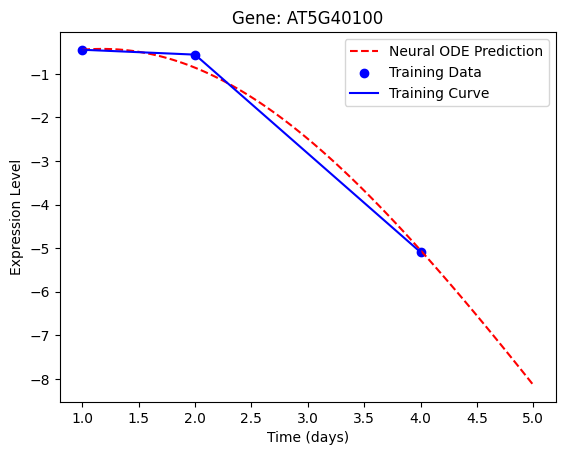

y0:  tensor([1.7784])


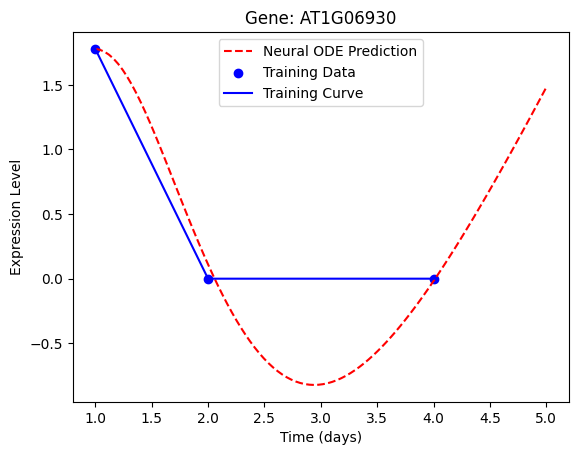

y0:  tensor([0.])


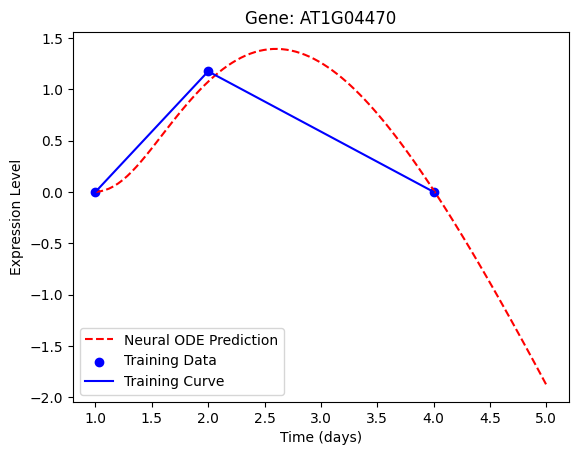

y0:  tensor([0.0554])


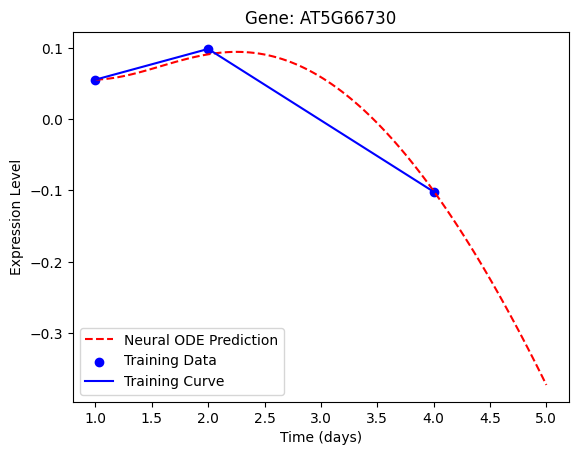

In [11]:

# Use the trained models to predict expression over the test time points.
predictions = {}  # Dictionary to store predictions for each gene

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        # The initial condition is taken from the training data (Day1 value)
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        print("y0: ",y0)
        # Solve the ODE over the test time points
        pred = odeint(ode_models[i], y0, test_time_tensor).squeeze().numpy()
        predictions[gene_id] = pred

        # Plot the test predictions (red dashed line) along with the original data points (blue dots)
        plt.figure()
        plt.plot(test_time_points, pred, 'r--', label="Neural ODE Prediction")
        # Plot original training points for this gene.
        # Note: Ensure the training time points match the data used during training.
        plt.scatter(time_points, gene_data[i], c='b', label="Training Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Training Curve")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

Epoch    0 | Total Loss: 2.0470 | Data Loss: 2.0407 | Physics Loss: 0.0637
Epoch  100 | Total Loss: 0.1696 | Data Loss: 0.0983 | Physics Loss: 0.7125
Epoch  200 | Total Loss: 0.0198 | Data Loss: 0.0177 | Physics Loss: 0.0205


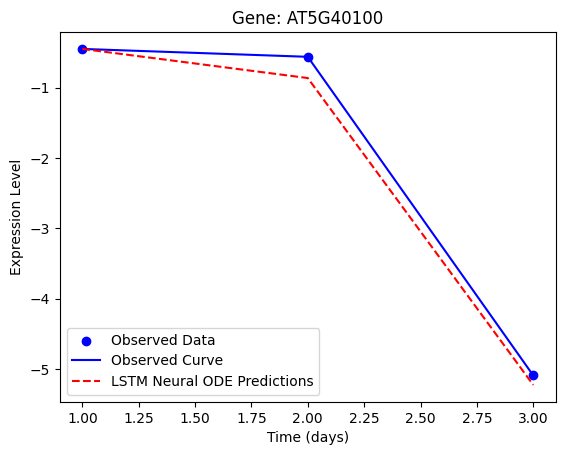

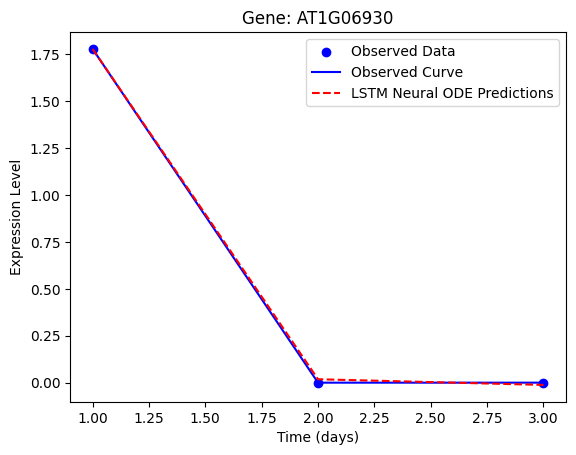

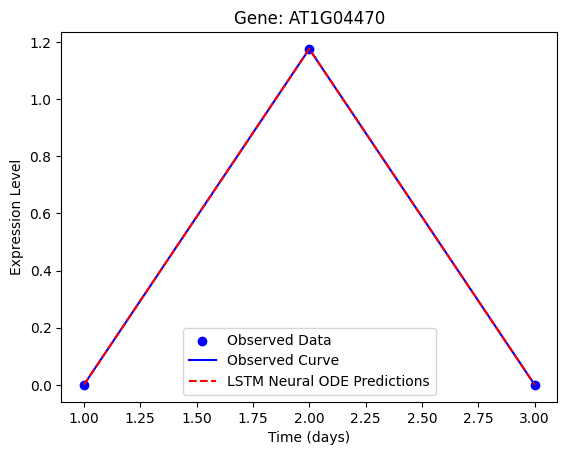

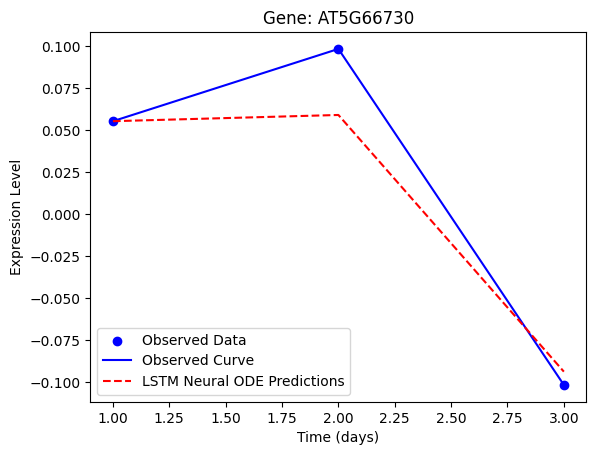


Learned ODE Parameters and Equations (LSTM version):
Gene: AT5G40100
  lstm.weight_ih_l0: tensor([[-0.3637,  0.3840],
        [-0.3075,  0.5027],
        [-0.3708,  0.2104],
        [-0.5310,  0.3423],
        [-0.4193,  0.3082],
        [-0.3506,  0.3159],
        [-0.6168,  0.3480],
        [-0.5924,  0.4196],
        [-0.2819,  0.6084],
        [-0.4364,  0.2664],
        [-0.8986,  0.8112],
        [-0.2336,  0.5472],
        [-0.3380,  0.3402],
        [-0.4293,  0.6141],
        [ 0.3525, -0.2800],
        [-0.4491,  0.4045],
        [ 0.1169,  0.2226],
        [ 0.0942,  0.1275],
        [-0.0314, -0.0060],
        [-0.2149, -0.1607],
        [ 0.1544, -0.1371],
        [ 0.0525, -0.0377],
        [-0.2223, -0.1255],
        [ 0.2008, -0.0626],
        [ 0.0365, -0.0668],
        [-0.0871,  0.0889],
        [ 0.2128,  0.1158],
        [ 0.1217, -0.1547],
        [-0.1347, -0.0040],
        [ 0.1750,  0.2011],
        [ 0.1081, -0.0359],
        [ 0.2437, -0.1542],
        [ 0.4

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Example data (each row is one gene, each column is a time point)
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Day1":  [-0.44796, 1.77836, 0.0, 0.05537],
    "Day2":  [-0.56015, 0.0, 1.17515, 0.09843],
    "Day3":  [-5.09196, 0.0, 0.0, -0.10176]
}
df = pd.DataFrame(data)
time_points = np.array([1.0, 2.0, 3.0], dtype=np.float32)
gene_data = df[["Day1", "Day2", "Day3"]].values  # Shape: (num_genes, num_time_points)

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE with LSTM
##############################################################################

class GeneSpecificODE_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        # Here, we use an LSTM to process a 2D input: [y, t]
        # We treat each evaluation as a sequence of length 1.
        self.lstm = nn.LSTM(input_size=2, hidden_size=16, num_layers=1, batch_first=True)
        self.linear = nn.Linear(16, 1)  # Map LSTM output to the derivative

    def forward(self, t, y):
        # y: shape (batch_size, 1) -- current gene expression.
        # We combine y and t into a 2-element feature.
        # Create a tensor for t of the same shape as y.
        t_tensor = torch.ones_like(y) * t  # shape (batch_size, 1)
        # Concatenate along the last dimension to form (batch_size, 2)
        combined = torch.cat([y, t_tensor], dim=-1)
        # Add sequence dimension: (batch_size, seq_len=1, input_size=2)
        seq_input = combined.unsqueeze(1)
        # Pass through the LSTM. Here, we ignore the hidden state between calls.
        lstm_out, _ = self.lstm(seq_input)
        # Take the output of the last time step and pass it through the linear layer.
        dy_dt = self.linear(lstm_out[:, -1, :])
        return dy_dt

# Initialize one LSTM-based ODE model per gene
n_genes = gene_data_tensor.shape[0]
ode_models_lstm = nn.ModuleList([GeneSpecificODE_LSTM() for _ in range(n_genes)])

##############################################################################
# Define the Training Loss Function
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_true = gene_data[i].unsqueeze(-1)  # shape: (num_time_points, 1)
        y0 = y_true[0].unsqueeze(0)  # initial condition

        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)
        data_loss = torch.mean((preds - y_true.squeeze()) ** 2)

        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        # Reshape 'p' to (batch_size, 1) before concatenating with 't_tensor'
        dy_dt_ode = torch.stack([ode_models[i](t, p.reshape(-1, 1)) for t, p in zip(time_points, preds)]).squeeze()
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models_lstm.parameters(), lr=0.01)
epochs = 300

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models_lstm, time_points_tensor, gene_data_tensor, lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# Plotting and Printing Results
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)
        preds = odeint(ode_models_lstm[i], y0, time_points_tensor).squeeze().numpy()
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="LSTM Neural ODE Predictions")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

##############################################################################
# Print Learned ODE Parameters and Equations for Each Gene
##############################################################################

print("\nLearned ODE Parameters and Equations (LSTM version):")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models_lstm[i]
    print(f"Gene: {gene_id}")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  {name}: {param.data}")

    # For the sake of interpretation, we note that the derivative is computed as:
    # dY/dt = Linear( LSTM( [Y, t] ) )
    # Here we extract the linear layer parameters.
    W_linear = model.linear.weight.detach().numpy().flatten()
    b_linear = model.linear.bias.detach().numpy().flatten()
    equation = f"d({gene_id})/dt = LSTM_output*({W_linear[0]:.4f}) + {b_linear[0]:.4f}"
    print("  " + equation + "\n")


In [27]:

data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Day1":  [-0.44796,    1.77836,     0.0,         0.05537   ],
    "Day2":  [-0.56015,    0.0,         1.17515,     0.09843   ],
    "Day4":  [-5.09196,    0.0,         0.0,        -0.10176   ],
}

df = pd.DataFrame(data)

In [28]:
# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # day1, day2, day4

# gene_data shape: (num_genes, num_time_points)
gene_data = df[["Day1", "Day2", "Day4"]].values  # 4 genes x 3 time points

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

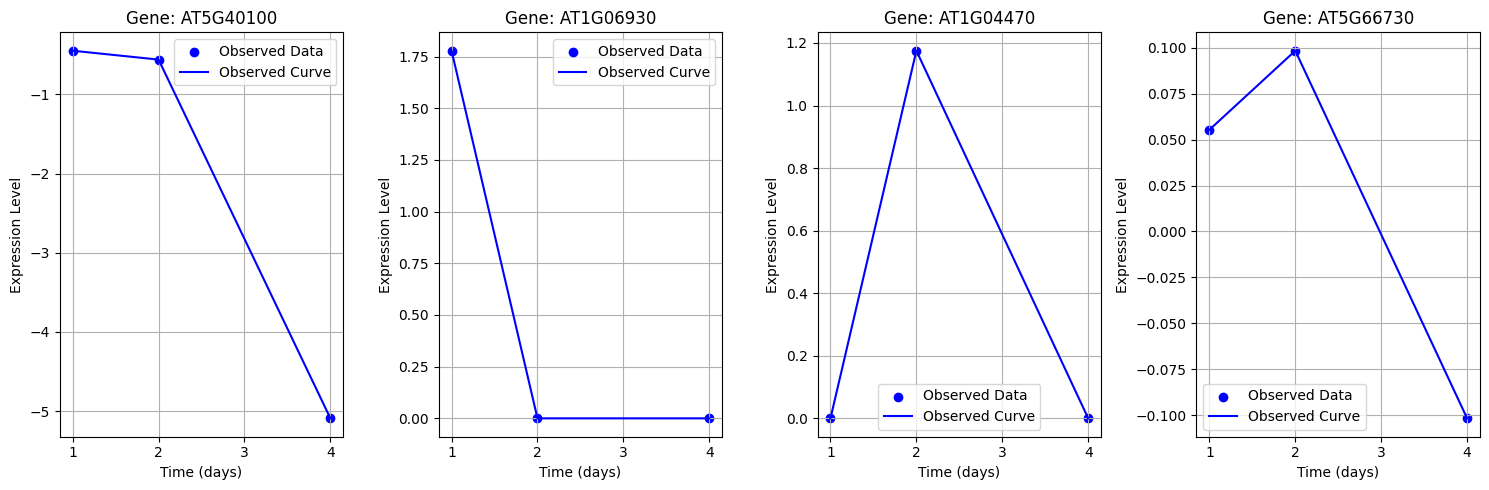

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


fig, axes = plt.subplots(1, len(df['Gene']), figsize=(15, 5))  # 1 row, 4 columns

for i, gene in enumerate(df['Gene']):
    axes[i].scatter(time_points, gene_data[i], c='b', label="Observed Data")
    axes[i].plot(time_points, gene_data[i], 'b-', label="Observed Curve")
    axes[i].set_title(f"Gene: {gene}")
    axes[i].set_xlabel("Time (days)")
    axes[i].set_ylabel("Expression Level")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Simulated Gene Expression Data:
                Gene      Day1      Day2      Day4
0       Gene_Const_1  1.177947  0.890936  0.863573
1       Gene_Const_2  1.079353  1.042657  0.965779
2       Gene_Const_3  0.949430  0.949757  1.111383
3          Gene_Up_1  1.001205  1.867844  4.046040
4          Gene_Up_2  0.991778  1.900087  3.762832
5          Gene_Up_3  0.993467  1.790945  3.968335
6        Gene_Down_1  3.959210  3.274262  0.864531
7        Gene_Down_2  4.082768  3.096395  0.872268
8        Gene_Down_3  4.027664  3.029681  1.107422
9   Gene_Transient_1  0.967045  2.865002  0.974785
10  Gene_Transient_2  0.806804  2.987933  1.032208
11  Gene_Transient_3  0.933933  2.899850  0.956734


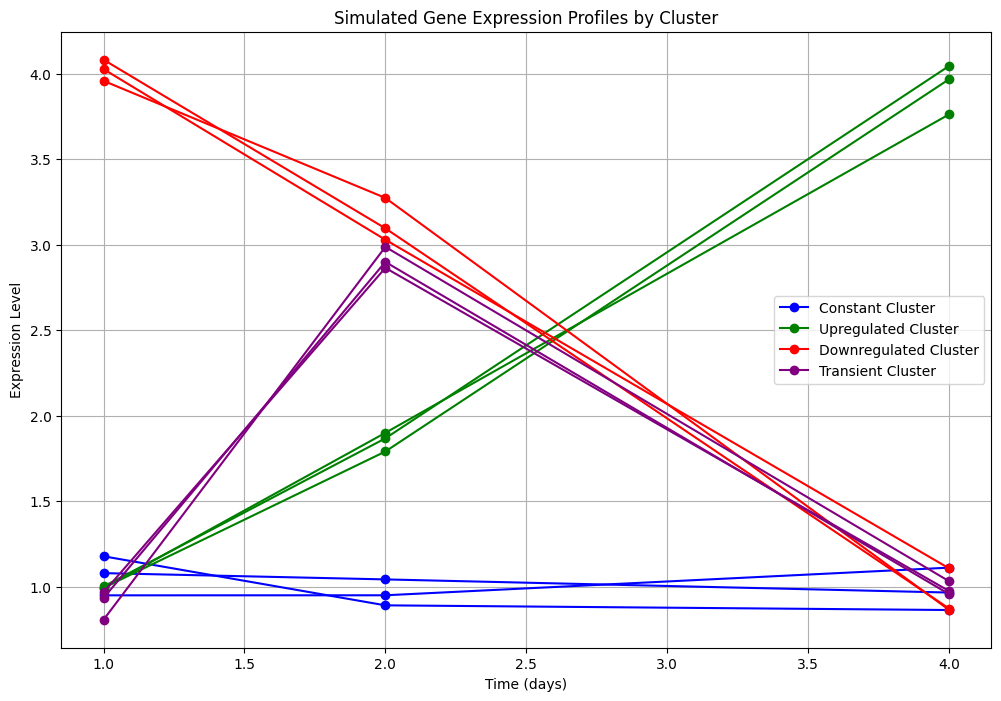

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time points (in days)
time_points = np.array([1, 2, 4])

# Number of genes per cluster
genes_per_cluster = 3

# Initialize lists to store gene names and their expression profiles
genes = []
expression_profiles = []

# 1. Constant Expression Cluster
for i in range(genes_per_cluster):
    gene_name = f"Gene_Const_{i+1}"
    genes.append(gene_name)
    # Simulate constant expression with some noise
    expression = np.random.normal(loc=1.0, scale=0.1, size=len(time_points))
    expression_profiles.append(expression)

# 2. Upregulated Expression Cluster
for i in range(genes_per_cluster):
    gene_name = f"Gene_Up_{i+1}"
    genes.append(gene_name)
    # Simulate upregulated expression
    expression = time_points + np.random.normal(loc=0.0, scale=0.1, size=len(time_points))
    expression_profiles.append(expression)

# 3. Downregulated Expression Cluster
for i in range(genes_per_cluster):
    gene_name = f"Gene_Down_{i+1}"
    genes.append(gene_name)
    # Simulate downregulated expression
    expression = 5 - time_points + np.random.normal(loc=0.0, scale=0.1, size=len(time_points))
    expression_profiles.append(expression)

# 4. Transient Expression Cluster
for i in range(genes_per_cluster):
    gene_name = f"Gene_Transient_{i+1}"
    genes.append(gene_name)
    # Simulate transient expression with a peak at day 2
    expression = np.array([1.0, 3.0, 1.0]) + np.random.normal(loc=0.0, scale=0.1, size=len(time_points))
    expression_profiles.append(expression)

# Create a DataFrame
expression_profiles = np.array(expression_profiles)
df = pd.DataFrame(data=expression_profiles, columns=[f"Day{int(day)}" for day in time_points])
df.insert(0, "Gene", genes)

# Display the DataFrame
print("Simulated Gene Expression Data:")
print(df)

# Plotting the expression profiles for each cluster
plt.figure(figsize=(12, 8))

# Plot each cluster with a different color
colors = ['blue', 'green', 'red', 'purple']
cluster_names = ['Constant', 'Upregulated', 'Downregulated', 'Transient']

for cluster_idx in range(4):
    start_idx = cluster_idx * genes_per_cluster
    end_idx = start_idx + genes_per_cluster
    for gene_idx in range(start_idx, end_idx):
        plt.plot(time_points, expression_profiles[gene_idx], marker='o', color=colors[cluster_idx], label=f"{cluster_names[cluster_idx]} Cluster" if gene_idx == start_idx else "")

plt.xlabel('Time (days)')
plt.ylabel('Expression Level')
plt.title('Simulated Gene Expression Profiles by Cluster')
plt.legend()
plt.grid(True)
plt.show()


Clustered Gene Expression Data:
                Gene      Day1      Day2      Day4  Cluster
0       Gene_Const_1  1.177947  0.890936  0.863573        2
1       Gene_Const_2  1.079353  1.042657  0.965779        2
2       Gene_Const_3  0.949430  0.949757  1.111383        2
3          Gene_Up_1  1.001205  1.867844  4.046040        0
4          Gene_Up_2  0.991778  1.900087  3.762832        0
5          Gene_Up_3  0.993467  1.790945  3.968335        0
6        Gene_Down_1  3.959210  3.274262  0.864531        3
7        Gene_Down_2  4.082768  3.096395  0.872268        3
8        Gene_Down_3  4.027664  3.029681  1.107422        3
9   Gene_Transient_1  0.967045  2.865002  0.974785        1
10  Gene_Transient_2  0.806804  2.987933  1.032208        1
11  Gene_Transient_3  0.933933  2.899850  0.956734        1


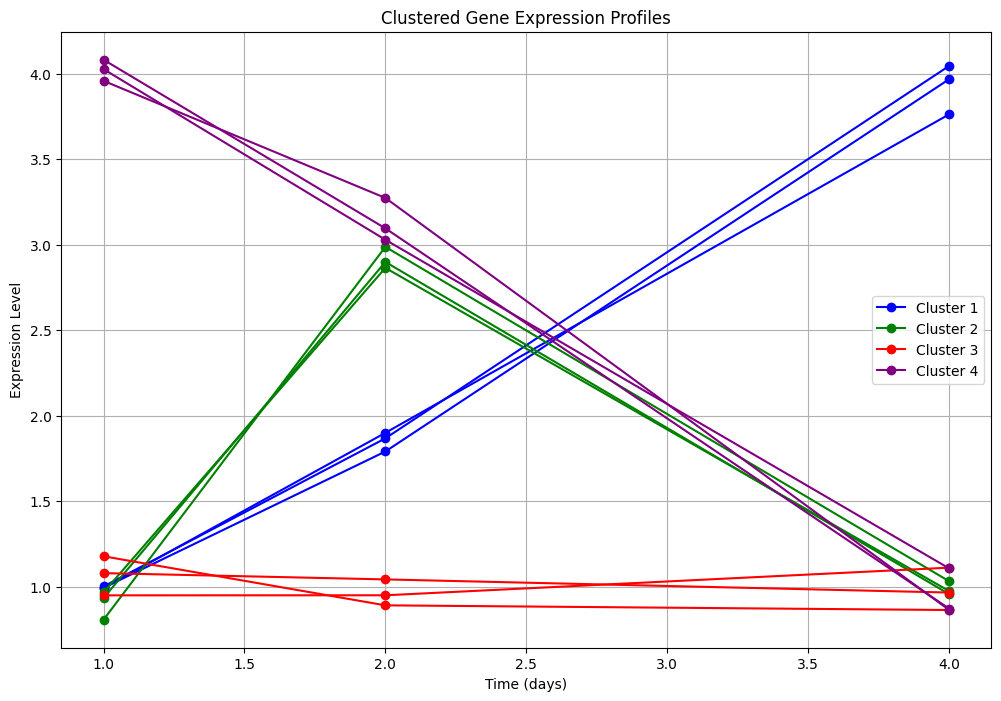

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# Extract expression data for clustering
expression_data = df.iloc[:, 1:].values  # Exclude the 'Gene' column

# Standardize the data
scaler = StandardScaler()
expression_data_scaled = scaler.fit_transform(expression_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(expression_data_scaled)

# Display the DataFrame with cluster assignments
print("Clustered Gene Expression Data:")
print(df)

# Plotting the clustered expression profiles
plt.figure(figsize=(12, 8))

# Define colors for each cluster
colors = ['blue', 'green', 'red', 'purple']
cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

for cluster in range(4):
    cluster_data = df[df['Cluster'] == cluster]
    for _, row in cluster_data.iterrows():
        plt.plot(time_points, row[1:-1], marker='o', color=colors[cluster], label=cluster_names[cluster] if _ == cluster_data.index[0] else "")

plt.xlabel('Time (days)')
plt.ylabel('Expression Level')
plt.title('Clustered Gene Expression Profiles')
plt.legend()
plt.grid(True)
plt.show()
